# **METHODOLOGY**

## **A) Data Cleaning and Preparation:**

1. **Removed the redundant columns:**
   - 1.1 Columns with high (>10K) unique values as they might lead to overfitting.
   - 1.2 Repeated columns pairs.
   - 1.3 Columns that are sub-divided from another column.

2. **Standardized the following values in the columns:**
   - 2.1 Misspelled, repeated values.
   - 2.2 Values less than some threshold that are at the tail end of the value counts.

## **B) Missing Value Handling:**

- **Imputed with Mode** wherever one value has disproportionately high counts.
- **Filled with "Others"** wherever missing value count is less than some threshold.
- **Deleted rows** that are very low in numbers and have missing values in multiple columns.

## **C) EDA (Exploratory Data Analysis):**

1. **Conducted Univariate Analysis** of all the feature columns to check their distribution.
2. **Bivariate Analysis** to dig deeper into the relationship of the dependent variable with each independent variable.
3. **Correlation Matrix** of the independent features.

## **D) Feature Engineering:**

- **Created a Stratified Train-Test Split** to ensure a similar proportion of classes in both training and test sets.
- Since all the columns came out to be categorical features, applied the **One Hot Encoding** transformation to convert these to numerics to be fed into the model.

## **E) Handling Class Imbalance:**

- Used under-sampling technique: **Tomek Links**. However, that did not resolve the issue.
- Combined that with **SMOTE Technique** (to synthesize data) to achieve a balanced dataset in the training class.

## **F) Model Initialization and Training:**

- Initialized and trained 3 ML models: **Logistic Regression**, **Random Forest Classifier**, and **XGBoost**. Got the following AUC-ROC scores:
  - 1. **Logistic Regression:** 0.739 (before hyperparameter tuning).
  - 2. **Random Forest Classifier:** 0.592
  - 3. **XGBoost:** 0.716

## **G) Hyperparameter Tuning:**

- **Logistic Regression:** The AUC-ROC score increased to 0.745 from 0.739 after hyperparameter tuning. This improvement suggests that fine-tuning the hyperparameters helped in better separating the classes.

## **H) Model Exporting:**

- Converted the model into a **joblib file** to use for predicting the test set.


#### Import all libraries/ packages and load the data

In [362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, auc, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

In [4]:
%matplotlib inline

In [5]:
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth',20)


In [6]:
leads_data = pd.read_csv('D:/Projects & Datasets/Case Study/Data Scientist Case Study/prob_2/sample_lead_data.csv',index_col=0)

In [7]:
leads_data.shape

(100000, 23)

In [8]:
leads_data.head()

,MkVendorID,SourceCode,VendorDescription,LeadType,VendorInternalCode,mkCampaignID,mkMarketingChannelId,MkMarketingChannel,Address,City,State,Country,Zip,SyCampusID,HighestEducation,Campus,OriginalSchool,OriginalDegree,AcademicStarts,Military,SIFProgramValue,Brand,MISC_SourDes
0,62190,"""SF49632""","""AllStar Search ...","""Default""","""ASD-10207028""",0,23,"""Aggregator Plus""","""704 Rt 9""","""Keeseville""","""New York""","""United States""","""12944""",43,"""Associates""","""042 Purdue Glob...","""UnderGradBIZ""","""Bachelor of Sci...",0,"""No""","""BSBA_HR""",Aggregator Plus,AllStar Search (...
1,61935,"""SF43320""","""TriAd (Bachelors)""","""Default""","""eea49354-e001-4...",0,1,"""Aggregator""","""140 warnell st""","""Pembroke""","""Georgia""","""United States""","""31321""",43,"""SomeCollegeMore...","""042 Purdue Glob...","""HS""","""Bachelor of Sci...",0,"""No""","""BSHA""",Aggregator,TriAd (Bachelors)
2,62373,"""SF56573""","""Higher Educatio...","""Default""",NaN,0,23,"""Aggregator Plus""",NaN,"""Del Valle""","""Texas""","""United States""","""78617""",43,NaN,"""042 Purdue Glob...","""GradCJ""","""Master of Science""",0,"""No""","""MSCJ""",Aggregator Plus,Higher Education...
3,61931,"""SF43316""","""ClassesUSA (Ass...","""Default""","""Tier2""",474199205,1,"""Aggregator""","""18000 Kelley rd.""","""Fort Myers Beach""","""Florida""","""United States""","""33931""",43,"""SomeCollegeLess...","""042 Purdue Glob...","""IT""","""Associate of Sc...",0,"""No""","""AASIT_NA""",Aggregator,ClassesUSA (Asso...
4,61978,"""SF46661""","""Business""","""Default""",NaN,0,23,"""Aggregator Plus""","""""","""Upper Marlboro""","""Maryland""","""United States""","""20774""",43,NaN,"""042 Purdue Glob...","""EDU""","""Master of Science""",0,"""No""","""MATK12""",Aggregator Plus,Business


In [9]:
leads_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   MkVendorID            100000 non-null  int64 
 1   SourceCode            100000 non-null  object
 2   VendorDescription     100000 non-null  object
 3   LeadType              94348 non-null   object
 4   VendorInternalCode    66405 non-null   object
 5   mkCampaignID          100000 non-null  int64 
 6   mkMarketingChannelId  100000 non-null  int64 
 7   MkMarketingChannel    100000 non-null  object
 8   Address               97539 non-null   object
 9   City                  99318 non-null   object
 10  State                 99896 non-null   object
 11  Country               99289 non-null   object
 12  Zip                   99983 non-null   object
 13  SyCampusID            100000 non-null  int64 
 14  HighestEducation      68410 non-null   object
 15  Campus            

#### Seggregate between numerical and categorical features and Check null values 

In [11]:
# Divide all columns into numerical & categorical
num_col = leads_data.dtypes[(leads_data.dtypes == 'int64') | (leads_data.dtypes == 'float64')].keys()
cat_col = leads_data.dtypes[~(leads_data.dtypes == 'int64') & ~(leads_data.dtypes == 'float64')].keys()

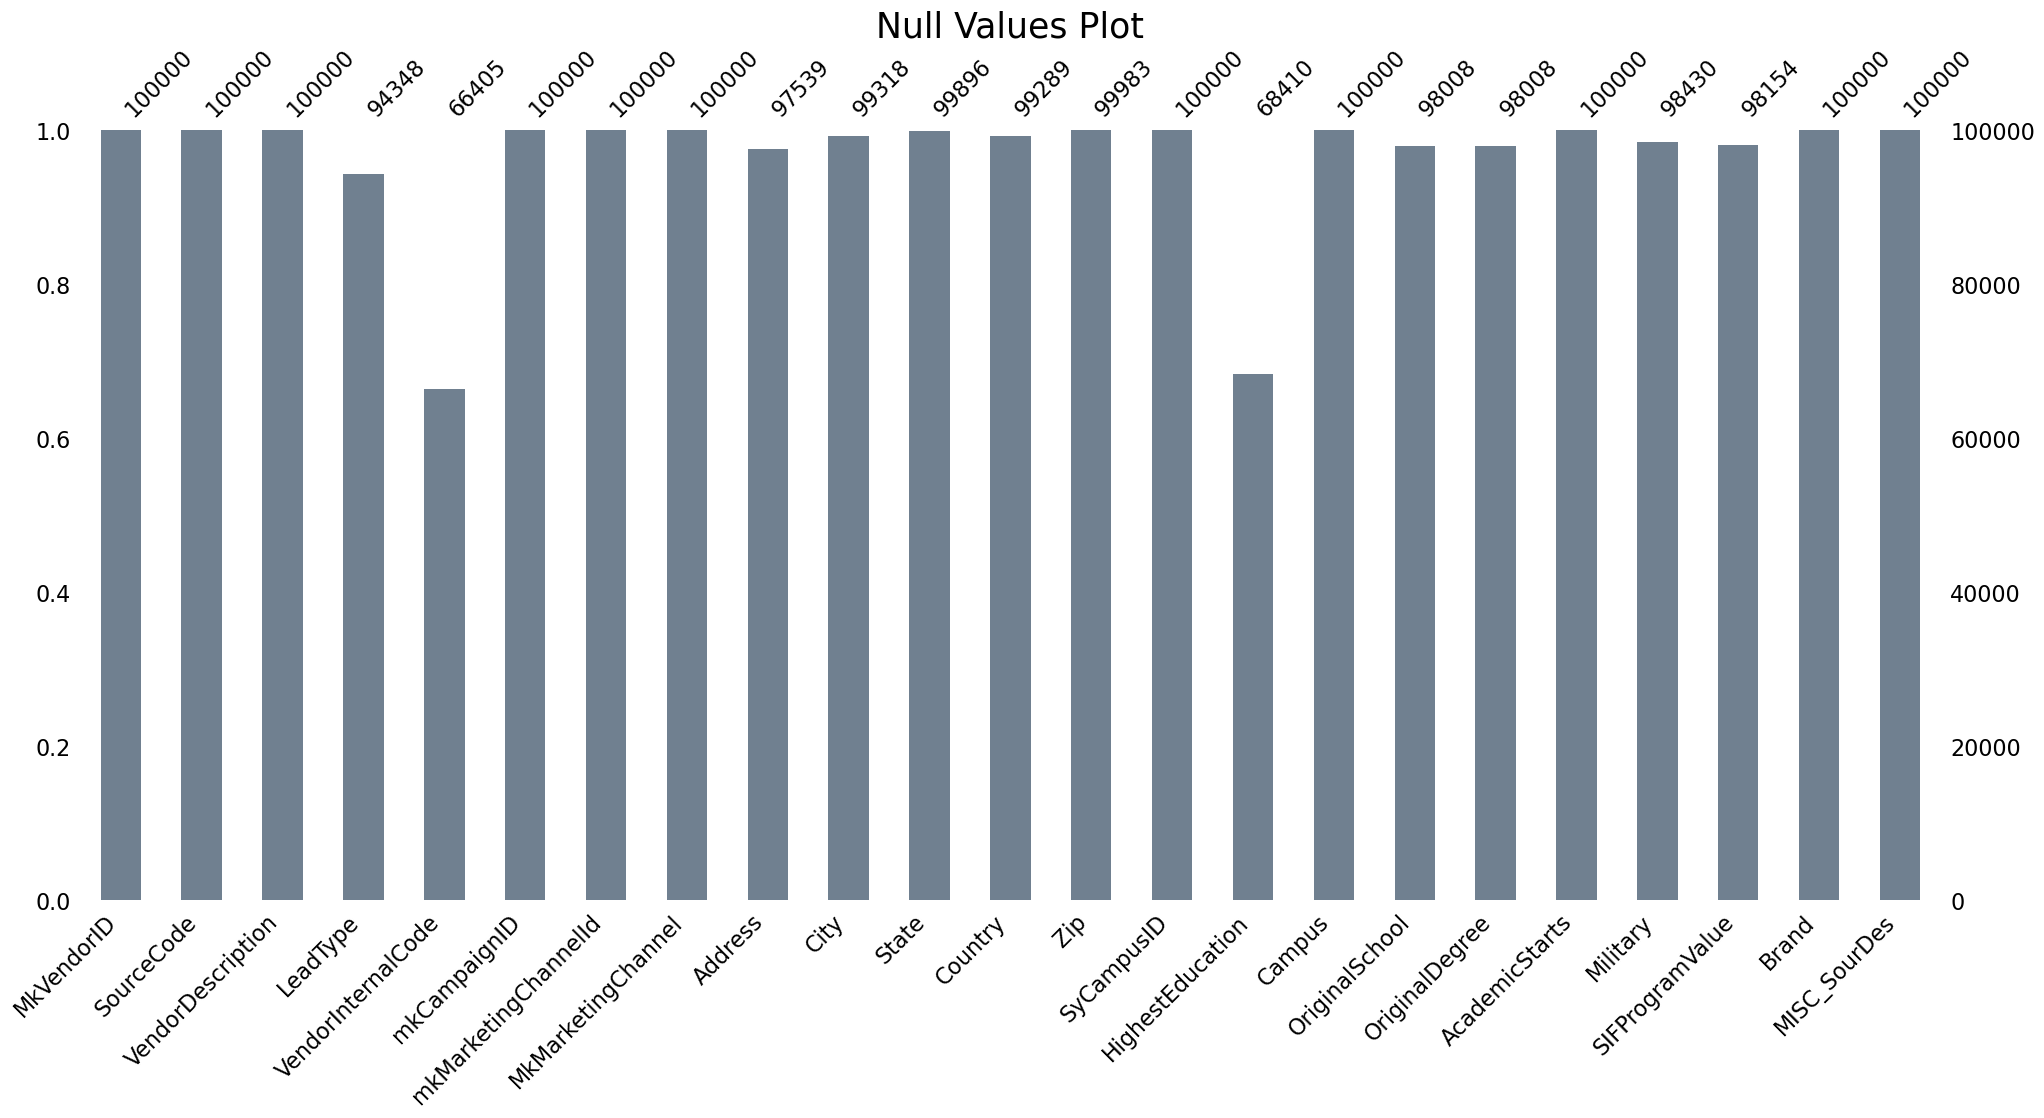

In [12]:
# Plot feature wise missing values
ms.bar(leads_data, color = 'slategrey')
plt.title("Null Values Plot",fontdict={'fontsize':25})
plt.show()

In [13]:
# Numerical columns: check missing values and unique values

missing_values_num = {}
for i in leads_data[num_col].columns:
    missing_values_num[i] = (leads_data[i].dtypes,leads_data[i].isnull().sum(),leads_data[i].nunique())
missing_values_num

NullValues_num = pd.DataFrame(data=missing_values_num.values(),index = missing_values_num.keys(), columns =['dtype','MissingValues','Unique values'])
NullValues_num['NullValues_pct'] = round(NullValues_num['MissingValues']/1000,2)
NullValues_num = NullValues_num.sort_values(by='NullValues_pct',ascending=False).iloc[:,[0,1,3,2]]
NullValues_num

,dtype,MissingValues,NullValues_pct,Unique values
MkVendorID,int64,0,0.0,286
mkCampaignID,int64,0,0.0,5112
mkMarketingChannelId,int64,0,0.0,34
SyCampusID,int64,0,0.0,15
AcademicStarts,int64,0,0.0,2


In [14]:
# Categorical columns: check missing values and unique values
missing_values_cat = {}
for i in leads_data[cat_col].columns:
    missing_values_cat[i] = (leads_data[i].dtypes,leads_data[i].isnull().sum(),leads_data[i].nunique())
missing_values_cat

NullValues_cat = pd.DataFrame(data=missing_values_cat.values(),index = missing_values_cat.keys(), columns =['dtype','MissingValues','Unique values'])
NullValues_cat['NullValues_pct'] = round(NullValues_cat['MissingValues']/1000,2)
NullValues_cat = NullValues_cat.sort_values(by=['NullValues_pct','Unique values'],ascending=False).iloc[:,[0,1,3,2]]
NullValues_cat

,dtype,MissingValues,NullValues_pct,Unique values
VendorInternalCode,object,33595,33.60,42717
HighestEducation,object,31590,31.59,25
LeadType,object,5652,5.65,10
Address,object,2461,2.46,78252
OriginalSchool,object,1992,1.99,22
OriginalDegree,object,1992,1.99,8
SIFProgramValue,object,1846,1.85,390
Military,object,1570,1.57,7
Country,object,711,0.71,137
City,object,682,0.68,13538


##### We see that column 'VendorInternalCode' has high null values %age and has high unique values. If we imput it, there are chances of it leading to biased or misleading results. It can lead to overfitting and increased computational costs if we encode it

##### Similarly columns 'Address' & 'Zip' have high unique value counts. So these are sparse columns and hence should be removed

In [17]:
leads_data = leads_data.drop(columns = ['VendorInternalCode','Address','Zip'], axis =1)

##### We also observe that columns 'VendorDescription', 'MISC_SourDes' & columns  'MkMarketingChannel', 'Brand' have similar values

In [19]:
# Check if these 2 pairs of columns are the same
leads_data['VendorDescription'] = leads_data['VendorDescription'].str.replace('"', '', regex=False)
print(leads_data['MISC_SourDes'].equals(leads_data['VendorDescription']))

leads_data['MkMarketingChannel'] = leads_data['MkMarketingChannel'].str.replace('"', '', regex=False)
print(leads_data['Brand'].equals(leads_data['MkMarketingChannel']))

True
True


In [20]:
# Since we have 2 pairs of duplicate columns, we remove one out of each pair
leads_data = leads_data.drop(columns = ['VendorDescription','MkMarketingChannel'], axis =1)

#### MkVendorID is an ID for 'MISC_SourDes' or 'VendorDescription' which can be grouped into 'mkMarketingChannelId' and 'Brand' respectively
#### Since this is a repetition as we have already covered 'Brand' column, we can remove these 2 columns


In [21]:
leads_data = leads_data.drop(columns = ['MkVendorID','mkMarketingChannelId'], axis =1)

#### Similarly 'SyCampusID' is an identifier for 'Campus' and can be removed

In [22]:
leads_data = leads_data.drop(columns = ['SyCampusID'], axis =1)

#### The 'SourceCode' column doesn't provide any intuitive information regarding it's importance with regards to target feature, nor do I have the domain knowledge to categorise/standardise it into multiple groups. So the computational cost of adding this feature in the model seems high. Hence removing this columns


In [23]:
leads_data = leads_data.drop('SourceCode',axis=1)

#### We observe that ~14% of the data is blank/null. And each city has low occurence (<1%) and high unique values. Moreover, we have State and Country columns which may capture geographical information at a broader level. Hence dropping this column


In [24]:
leads_data = leads_data.drop('City',axis=1)

#### Column 'MISC_SourDes' is grouped into 'Brand' column. So we can drop the column MISC_SourDes since Brand column will help reduce the computational efforts in creating the model

In [25]:
leads_data = leads_data.drop('MISC_SourDes',axis=1)

In [26]:
leads_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   LeadType          94348 non-null   object
 1   mkCampaignID      100000 non-null  int64 
 2   State             99896 non-null   object
 3   Country           99289 non-null   object
 4   HighestEducation  68410 non-null   object
 5   Campus            100000 non-null  object
 6   OriginalSchool    98008 non-null   object
 7   OriginalDegree    98008 non-null   object
 8   AcademicStarts    100000 non-null  int64 
 9   Military          98430 non-null   object
 10  SIFProgramValue   98154 non-null   object
 11  Brand             100000 non-null  object
dtypes: int64(2), object(10)
memory usage: 9.9+ MB


#### Data Cleanup

##### Columns where we can see that values are either mis-spelled or non-standardized, can be grouped together into a single column

In [28]:
# Remove the double inverted commas from the values

columns_to_clean = ['HighestEducation','LeadType','OriginalDegree','Military', 'Country', 'State','Campus','OriginalSchool','SIFProgramValue']
for column in columns_to_clean:
    leads_data[column] = leads_data[column].str.replace('"', '', regex=False)

#### Highest Education

In [31]:
leads_data['HighestEducation'].value_counts(dropna=False,normalize=True).round(3)

NaN                                         0.316
HighSchool                                  0.302
SomeCollegeLessThan2                        0.169
GED                                         0.071
Associates                                  0.060
Bachelors                                   0.036
SomeCollegeMoreThan2                        0.036
Masters                                     0.007
BachelorDegree                              0.001
DoctoralDegree                              0.001
HSGED                                       0.001
PostGrad                                    0.001
AssocDegree                                 0.000
SelectEducation                             0.000
MasterDegree                                0.000
SomeCollegeLes                              0.000
Still in High School                        0.000
NursingDiploma                              0.000
                                            0.000
NONE                                        0.000


In [32]:
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['BachelorDegree','Bachelors'],'Bachelors') 
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['SomeCollegeLessThan2','SomeCollegeMoreThan2','SomeCollegeLes',
                                                                        'Some College (1-19 Quarter Credit)','Some College (20 or more Quarter Credit)',
                                                                        ],'Still in College') 
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['Associates','AssocDegree'],'Associate') 
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['HighSchool','GED','HSGED','NursingDiploma'],'High School') 
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['Still in High School','Still in high school'],'Still in High School')
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['Masters','MasterDegree','DoctoralDegree',
                                                                        'PostGrad','Masters'],'Post Graduation') 
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['SelectEducation','NONE','','NoEduc',
                                                                        'Select One','0'],'Unknown')
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['Some College'],'In College'

In [33]:
# Since there are high number of missing values in this column, and this may not be missing at random, so we fill the missing values by 'Unknown'
leads_data['HighestEducation'].fillna('Unknown', inplace=True)

In [34]:
leads_data['HighestEducation'].value_counts(dropna=False,normalize=True).round(3)

High School             0.374
Unknown                 0.316
Still in College        0.205
Associate               0.060
Bachelors               0.037
Post Graduation         0.008
Still in High School    0.000
Name: HighestEducation, dtype: float64

#### LeadType


In [36]:
leads_data['LeadType'].value_counts(dropna=False,normalize=True).round(3)

Default           0.851
NaN               0.057
Yes               0.056
Veteran           0.013
Active            0.012
MilitarySpouse    0.004
Military          0.004
DOD               0.002
Reserve           0.001
VeteranSpouse     0.001
NationalGuard     0.001
Name: LeadType, dtype: float64

In [37]:
leads_data['LeadType'] = leads_data['LeadType'].replace(['Veteran','MilitarySpouse','Military','VeteranSpouse',
                                                         'NationalGuard','Reserve','DOD'],'Veteran/Military')
leads_data['LeadType'] = leads_data['LeadType'].replace(['Yes','Active'],'Yes')
leads_data['LeadType'] = leads_data['LeadType'].replace(['Default'],'Default')

In [38]:
# Majority leads are default and missing value indicate that people did not bother filling this column, hence filling missing values by 'default'
leads_data['LeadType'].fillna('Default', inplace=True)

In [39]:
leads_data['LeadType'].value_counts(dropna=False,normalize=True).round(3)

Default             0.907
Yes                 0.067
Veteran/Military    0.026
Name: LeadType, dtype: float64

#### OriginalDegree

In [41]:
leads_data['OriginalDegree'].value_counts(dropna=False,normalize=True).round(3)

Bachelor of Science              0.690
Associate of Science             0.134
Certificate                      0.068
Master of Science                0.062
NaN                              0.020
Juris Doctor                     0.014
Graduate Level Certificate       0.010
Doctorate in Nursing Practice    0.002
Microcredential                  0.000
Name: OriginalDegree, dtype: float64

In [42]:
leads_data['OriginalDegree'] = leads_data['OriginalDegree'].replace(['Bachelor of Science'],'Bachelor of Science')
leads_data['OriginalDegree'] = leads_data['OriginalDegree'].replace(['Associate of Science'],'Associate of Science')
leads_data['OriginalDegree'] = leads_data['OriginalDegree'].replace(['Master of Science'],'Master of Science')
leads_data['OriginalDegree'] = leads_data['OriginalDegree'].replace(['Certificate'],'Certificate')
leads_data['OriginalDegree'] = leads_data['OriginalDegree'].replace(['Juris Doctor','Graduate Level Certificate',
                                                                     'Microcredential','Doctorate in Nursing Practice'],'Others')


In [43]:
leads_data['OriginalDegree'].value_counts(dropna=False,normalize=True).round(3)

Bachelor of Science     0.690
Associate of Science    0.134
Certificate             0.068
Master of Science       0.062
Others                  0.026
NaN                     0.020
Name: OriginalDegree, dtype: float64

#### Original School

In [45]:
leads_data['OriginalSchool'].value_counts(dropna=False,normalize=True).round(3)

UnderGradBIZ    0.231
AAS             0.230
HS              0.184
UnderGradCJ     0.128
IT              0.067
PL              0.033
NaN             0.020
GradBIZ         0.016
MSAAS           0.016
CONCORD         0.014
MSN             0.014
EDU             0.009
NUR             0.007
MSHS            0.007
GE              0.004
MSIT            0.004
ADN             0.004
GradCJ          0.003
MSLS            0.003
MSE             0.002
AV              0.002
NA              0.001
MSHE            0.001
Name: OriginalSchool, dtype: float64

In [46]:
# Grouping values (with < 1% of the total values of column) with 'Others'
threshold = 0.02 * len(leads_data)
value_counts = leads_data['OriginalSchool'].value_counts()
leads_data['OriginalSchool'] = leads_data['OriginalSchool'].apply(lambda x: x if pd.isna(x) or value_counts[x] >= threshold else 'Others')

In [47]:
leads_data['OriginalSchool'].value_counts(dropna=False)

UnderGradBIZ    23147
AAS             23023
HS              18370
UnderGradCJ     12795
Others          10675
IT               6652
PL               3346
NaN              1992
Name: OriginalSchool, dtype: int64

In [48]:
leads_data[(leads_data['OriginalDegree'].isnull()) & (leads_data['OriginalSchool'].isnull())]['AcademicStarts'].value_counts()

0    1952
1      40
Name: AcademicStarts, dtype: int64

In [49]:
# Since OriginalDegree & OriginalSchool columns have same rows with missing values, we can remove these rows, as it is <2% of the data
leads_data = leads_data.dropna(subset='OriginalDegree',axis=0)

In [ ]:
leads_data.shape

#### Military

In [52]:
leads_data['Military'].value_counts(dropna=False,normalize=True).round(3)

No                0.883
Yes               0.092
NaN               0.016
NO                0.004
                  0.004
YES               0.001
MilitarySpouse    0.000
Name: Military, dtype: float64

In [53]:
# Standardizing all the values with Yes,No,Unknown

leads_data['Military'] = leads_data['Military'].replace(['No','NO','0'],'No')
leads_data['Military'] = leads_data['Military'].replace(['Yes','YES','MilitarySpouse'],'Yes')
leads_data['Military'] = leads_data['Military'].replace([''],'Unknown')

In [54]:
# Since the military values are missing, we can replace these with unknown
leads_data['Military'] = leads_data['Military'].fillna('Unknown')

In [55]:
leads_data['Military'].value_counts(dropna=False,normalize=True).round(3)

No         0.887
Yes        0.093
Unknown    0.019
Name: Military, dtype: float64

#### Campus

In [57]:
leads_data['Campus'].value_counts()

042 Purdue Global Online          90957
118 Purdue Global Indianapolis     3398
848 Purdue Global Concord          1360
027 Purdue Global Lincoln           572
038 Purdue Global Cedar Rapids      449
039 Purdue Global Des Moines        367
037 Purdue Global Davenport         232
098 Purdue Global Lewiston          174
152 Purdue Global Augusta           134
119 Purdue Global St. Louis         123
117 Purdue Global Milwaukee          75
025 Purdue Global Hagerstown         74
147 Purdue Global Rockville          68
040 Purdue Global Mason City         24
036 Purdue Global Cedar Falls         1
Name: Campus, dtype: int64

In [58]:
# Grouping values (with < 0.5% of the total values of column) with 'Others'
threshold = 0.005 * len(leads_data)
value_counts = leads_data['Campus'].value_counts()
leads_data['Campus'] = leads_data['Campus'].apply(lambda x: x if pd.isna(x) or value_counts[x] >= threshold else 'Others')


In [59]:
leads_data['Campus'].value_counts()

042 Purdue Global Online          90957
118 Purdue Global Indianapolis     3398
Others                             1721
848 Purdue Global Concord          1360
027 Purdue Global Lincoln           572
Name: Campus, dtype: int64

#### Country

In [61]:
leads_data['Country'].value_counts(dropna=False)

United States                           96752
NaN                                       618
India                                      67
                                           57
Canada                                     46
Georgia, Republic of                       43
Nigeria                                    28
United Arab Emirates                       18
United Kingdom                             17
Germany                                    15
Bahamas                                    14
Saudi Arabia                               13
Philippines                                11
Jamaica                                    11
China                                      10
Kenya                                       9
Puerto Rico                                 9
Japan                                       8
South Africa                                8
Guam                                        8
Georgia                                     7
Poland                            

In [62]:
# Replacing all countries except 'United States' with 'Others', keeping NaN as is
leads_data['Country'] = leads_data['Country'].apply(lambda x: 'USA' if x == 'United States' else ('Others' if pd.notna(x) else x))

In [63]:
leads_data['Country'].value_counts(dropna=False)

USA       96752
Others      638
NaN         618
Name: Country, dtype: int64

In [64]:
# for nulls values in Country, we check their states if these belong to US, and replace the nulls in those instances with US
us_states = list(leads_data[(leads_data['Country'].isnull()) & (leads_data['State'] != '')]['State'])
leads_data.loc[leads_data['State'].isin(us_states) & leads_data['Country'].isnull(), 'Country'] = 'USA'


In [65]:
# we remove the remaining null values of Country since State is also not present 
leads_data = leads_data.dropna(subset='Country',axis=0)


#### State

In [67]:
leads_data['State'].value_counts(dropna=False)

Texas                                      9917
California                                 5803
Florida                                    5780
New York                                   5432
Georgia                                    4813
Ohio                                       3948
North Carolina                             3881
Illinois                                   3875
Pennsylvania                               3582
Indiana                                    3505
Michigan                                   3001
Virginia                                   2548
Tennessee                                  2422
Washington                                 2221
New Jersey                                 2140
South Carolina                             2059
Alabama                                    2049
Arizona                                    1965
Missouri                                   1924
Louisiana                                  1909
Maryland                                

In [68]:
# Grouping values (with < 1% of the total values of column) with 'Others'
threshold = 0.03 * len(leads_data)
value_counts = leads_data['State'].value_counts()
leads_data['State'] = leads_data['State'].apply(lambda x: x if pd.isna(x) or value_counts[x] >= threshold else 'Others')

In [69]:
leads_data['State'] = leads_data['State'].fillna('Others')

#### SIFProgramValue

In [71]:
leads_data['SIFProgramValue'].value_counts(dropna=False)

BSPAD                6368
BSBA                 4802
BSHA                 3082
BSECA                2874
HMD_NUR              2867
BSCJ                 2867
BSA                  2820
MEDAST               2820
BSHSYFS              2713
AASBA                2493
BSABA                2329
BSHS                 2220
BSNUT                2155
AASCJC               1985
HMD                  1984
BSHW                 1783
MBCC                 1776
BSCJ_CSI             1649
UEC                  1621
BSCJ_FP              1513
NaN                  1449
PSYC                 1442
AASIT                1131
BSBA_MGMT             993
HSCFS_CERT            964
AASLSS                955
BSIT_IST              901
BSCJ_LE               893
BSLIS                 853
MSPY                  839
BSBA_REAL             785
BSIT_PSD              778
BSHIM                 716
BHUSER                688
BSCYBSEC              635
AASAC                 621
BSBA_SCML             600
HMD_BIZ               581
BSBA_HR     

In [72]:
# Grouping values (with < 2% of the total values of column) with 'Others'
threshold = 0.025 * len(leads_data)
value_counts = leads_data['SIFProgramValue'].value_counts()
leads_data['SIFProgramValue'] = leads_data['SIFProgramValue'].apply(lambda x: x if pd.isna(x) or value_counts[x] >= threshold else 'Others')

# Replace missing values with 'Others', as these may not be missing at random
leads_data['SIFProgramValue'] = leads_data['SIFProgramValue'].fillna('Others')

In [73]:
leads_data['SIFProgramValue'].value_counts(dropna=False)

Others     64192
BSPAD       6368
BSBA        4802
BSHA        3082
BSECA       2874
BSCJ        2867
HMD_NUR     2867
MEDAST      2820
BSA         2820
BSHSYFS     2713
AASBA       2493
Name: SIFProgramValue, dtype: int64

#### Brand

In [75]:
leads_data['Brand'].value_counts()

Aggregator                     48450
Aggregator Plus                30842
Search Marketing - SEO          5396
SEM Brand                       3966
SEM NonBrand                    3783
Social Display                  2449
Online Display                   780
YouTube                          497
Guild                            493
SAO                              286
Military B2B                     132
Remarketing Genesys Process      128
Live Chat                        116
SAO National Account              91
SAO Non National Account          76
Inbound Calls                     72
International                     50
Furloughed Initiative             45
Brand Military                    38
Email_Internal                    33
Community College                 28
MSP Transfers                     23
Search Marketing - SEM            22
Referral                          16
GOK                               16
Brand Vertical                    15
PDL                               15
D

In [76]:
# Grouping values in 'Brand' (with < 1% of the total values of column) with 'Others'
threshold = 0.01 * len(leads_data)
value_counts = leads_data['Brand'].value_counts()
leads_data['Brand'] = leads_data['Brand'].apply(lambda x: x if value_counts[x] >= threshold else 'Others')

In [77]:
leads_data['Brand'].value_counts()

Aggregator                48450
Aggregator Plus           30842
Search Marketing - SEO     5396
SEM Brand                  3966
SEM NonBrand               3783
Others                     3012
Social Display             2449
Name: Brand, dtype: int64

#### mkCampaignID

In [79]:
leads_data['mkCampaignID'].value_counts()

0            84514
61989         3125
13754         1544
3             1261
62216          417
             ...  
10503703         1
472823086        1
495981616        1
476514703        1
20300039         1
Name: mkCampaignID, Length: 5064, dtype: int64

In [80]:
# Although this column consists of numerical values, it is highly skewed and 'mkCampaignID' seems like an identifier 
# So we should treat it as categorical variable & group values with count <1% as 'Others'

threshold = 0.01 * len(leads_data)
value_counts = leads_data['mkCampaignID'].value_counts()
leads_data['mkCampaignID'] = leads_data['mkCampaignID'].apply(lambda x: x if value_counts[x] >= threshold else 'Others')


In [81]:
leads_data['mkCampaignID'].value_counts()

0         84514
Others     7454
61989      3125
13754      1544
3          1261
Name: mkCampaignID, dtype: int64

In [82]:
# Convert all columns into object 
for col in leads_data.columns:
    leads_data[col] = leads_data[col].astype('object')


In [83]:
leads_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97898 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LeadType          97898 non-null  object
 1   mkCampaignID      97898 non-null  object
 2   State             97898 non-null  object
 3   Country           97898 non-null  object
 4   HighestEducation  97898 non-null  object
 5   Campus            97898 non-null  object
 6   OriginalSchool    97898 non-null  object
 7   OriginalDegree    97898 non-null  object
 8   AcademicStarts    97898 non-null  object
 9   Military          97898 non-null  object
 10  SIFProgramValue   97898 non-null  object
 11  Brand             97898 non-null  object
dtypes: object(12)
memory usage: 9.7+ MB


In [84]:
leads_data.describe().transpose()

,count,unique,top,freq
LeadType,97898,3,Default,89039
mkCampaignID,97898,5,0,84514
State,97898,12,Others,44361
Country,97898,2,USA,97260
HighestEducation,97898,7,High School,37049
Campus,97898,5,042 Purdue Globa...,90952
OriginalSchool,97898,7,UnderGradBIZ,23147
OriginalDegree,97898,5,Bachelor of Science,68959
AcademicStarts,97898,2,0,96639
Military,97898,3,No,86976


## EDA

### Univariate Analysis

#### Creating countplot for each categorical variable to check frequency distribution & find out dominant categories 

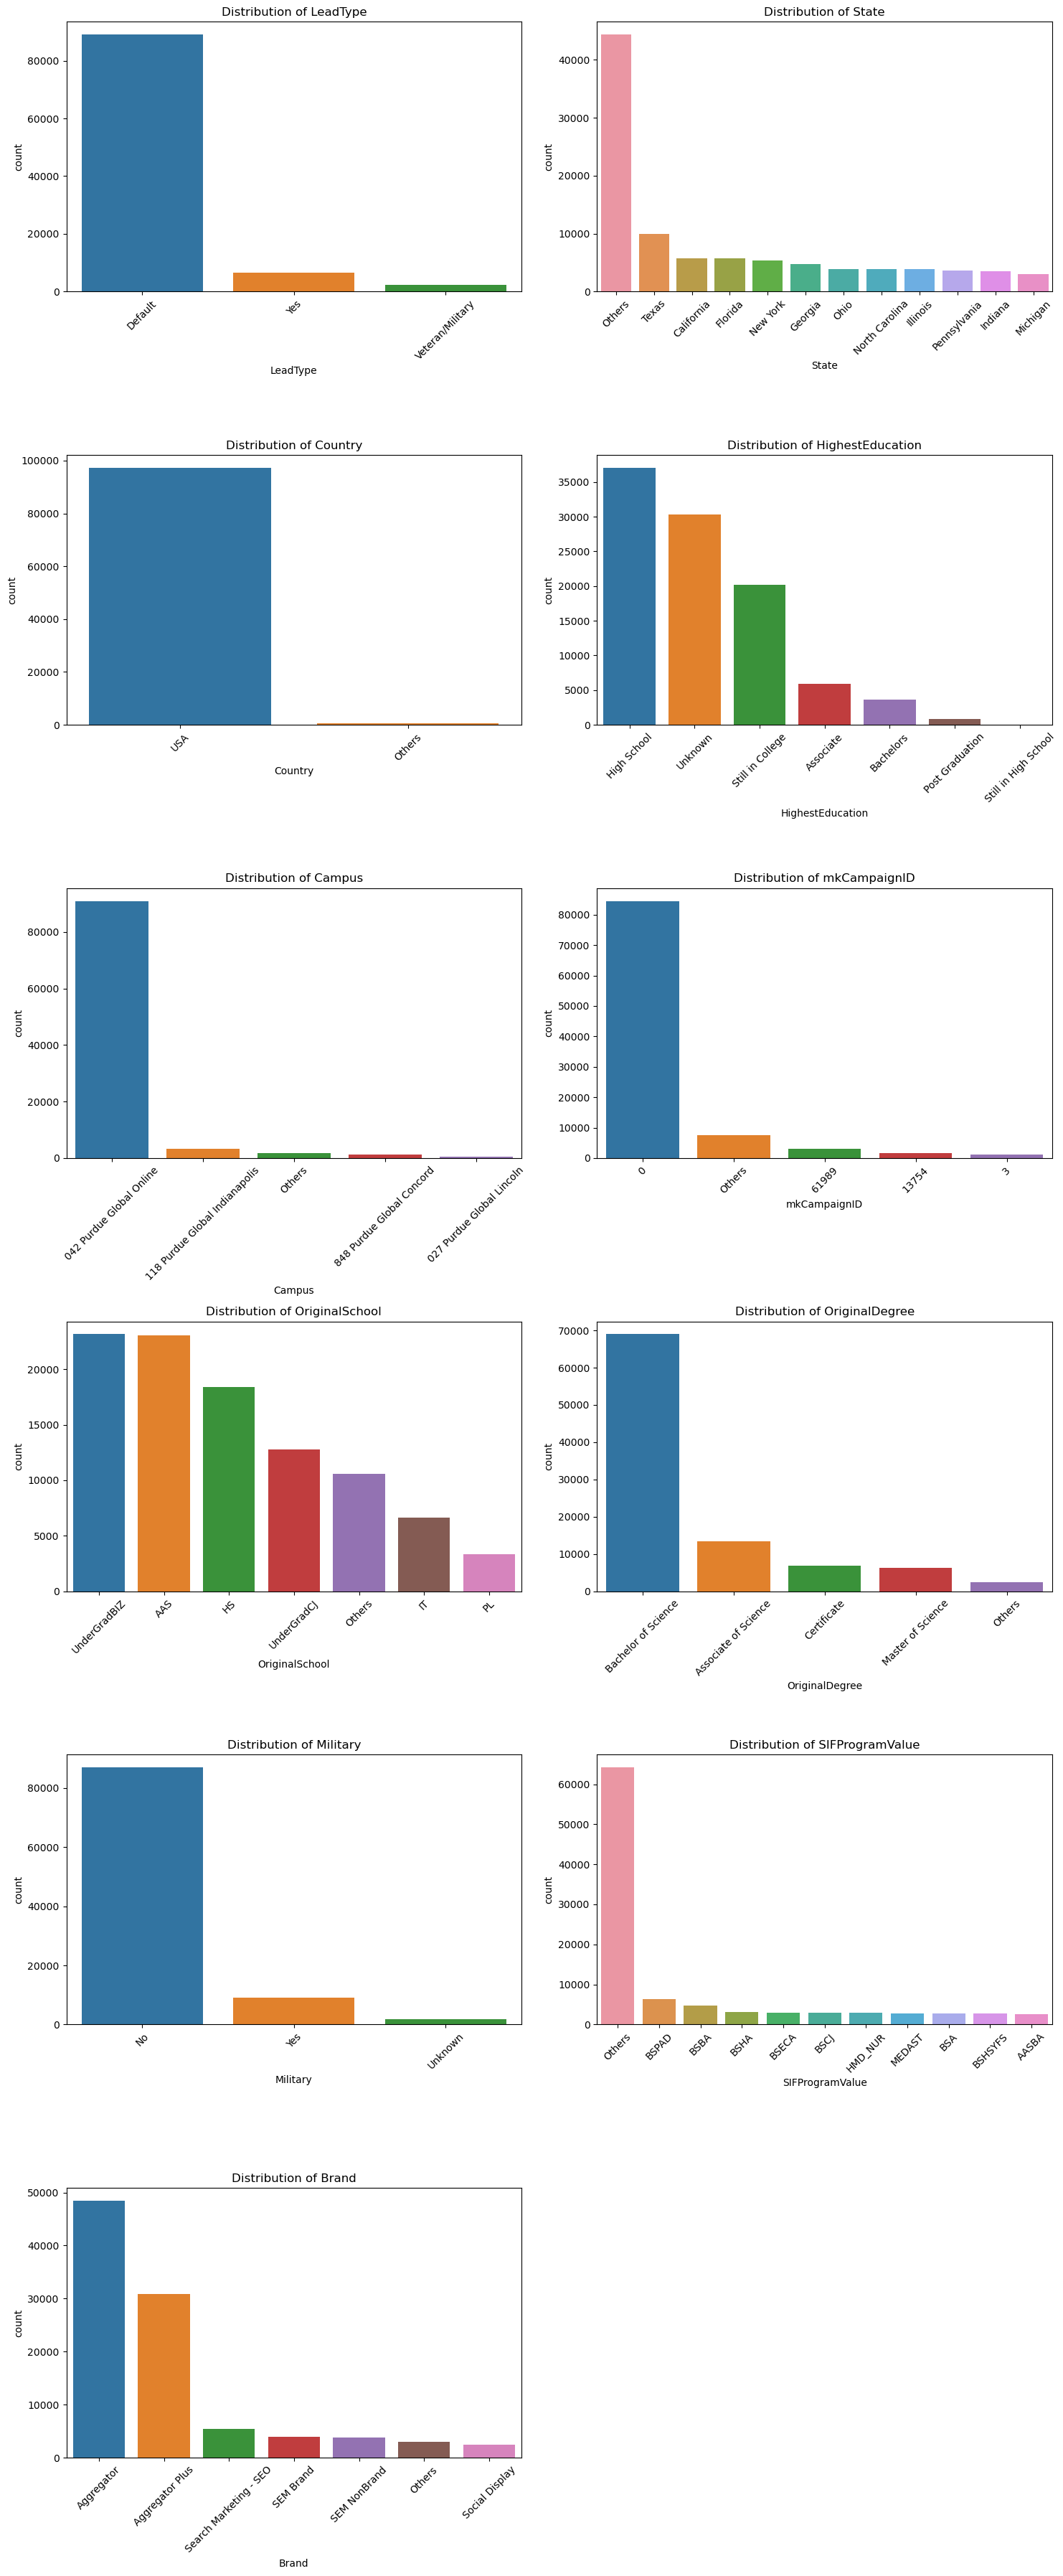

In [88]:
feature_columns = ['LeadType', 'State', 'Country', 'HighestEducation', 'Campus', 'mkCampaignID',
                       'OriginalSchool', 'OriginalDegree', 'Military', 'SIFProgramValue', 'Brand']

n_cols = 2
n_rows = (len(feature_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 6))
axes = axes.flatten()  

for i, col in enumerate(feature_columns):
    sns.countplot(x=col, data=leads_data, ax=axes[i], order=leads_data[col].value_counts().index)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)
    

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### We observe that only 'Highest Education', 'Original Shool', 'Brand' doesn't have skewed distributed. Whereas all other features' values are skewed heavily towards one dominant value. For example: In 'country' column, almost all the leads are from USA

#### Check the distribution of Target Variable

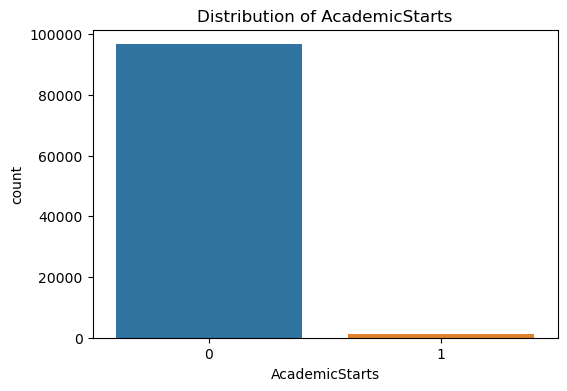

In [90]:
plt.figure(figsize=(6, 4))
sns.countplot(x='AcademicStarts', data=leads_data)
plt.title('Distribution of AcademicStarts')
plt.show()


### Bivariate analysis

#### Plot categorical features against the target


In [93]:
leads_data['AcademicStarts'] = pd.to_numeric(leads_data['AcademicStarts'])

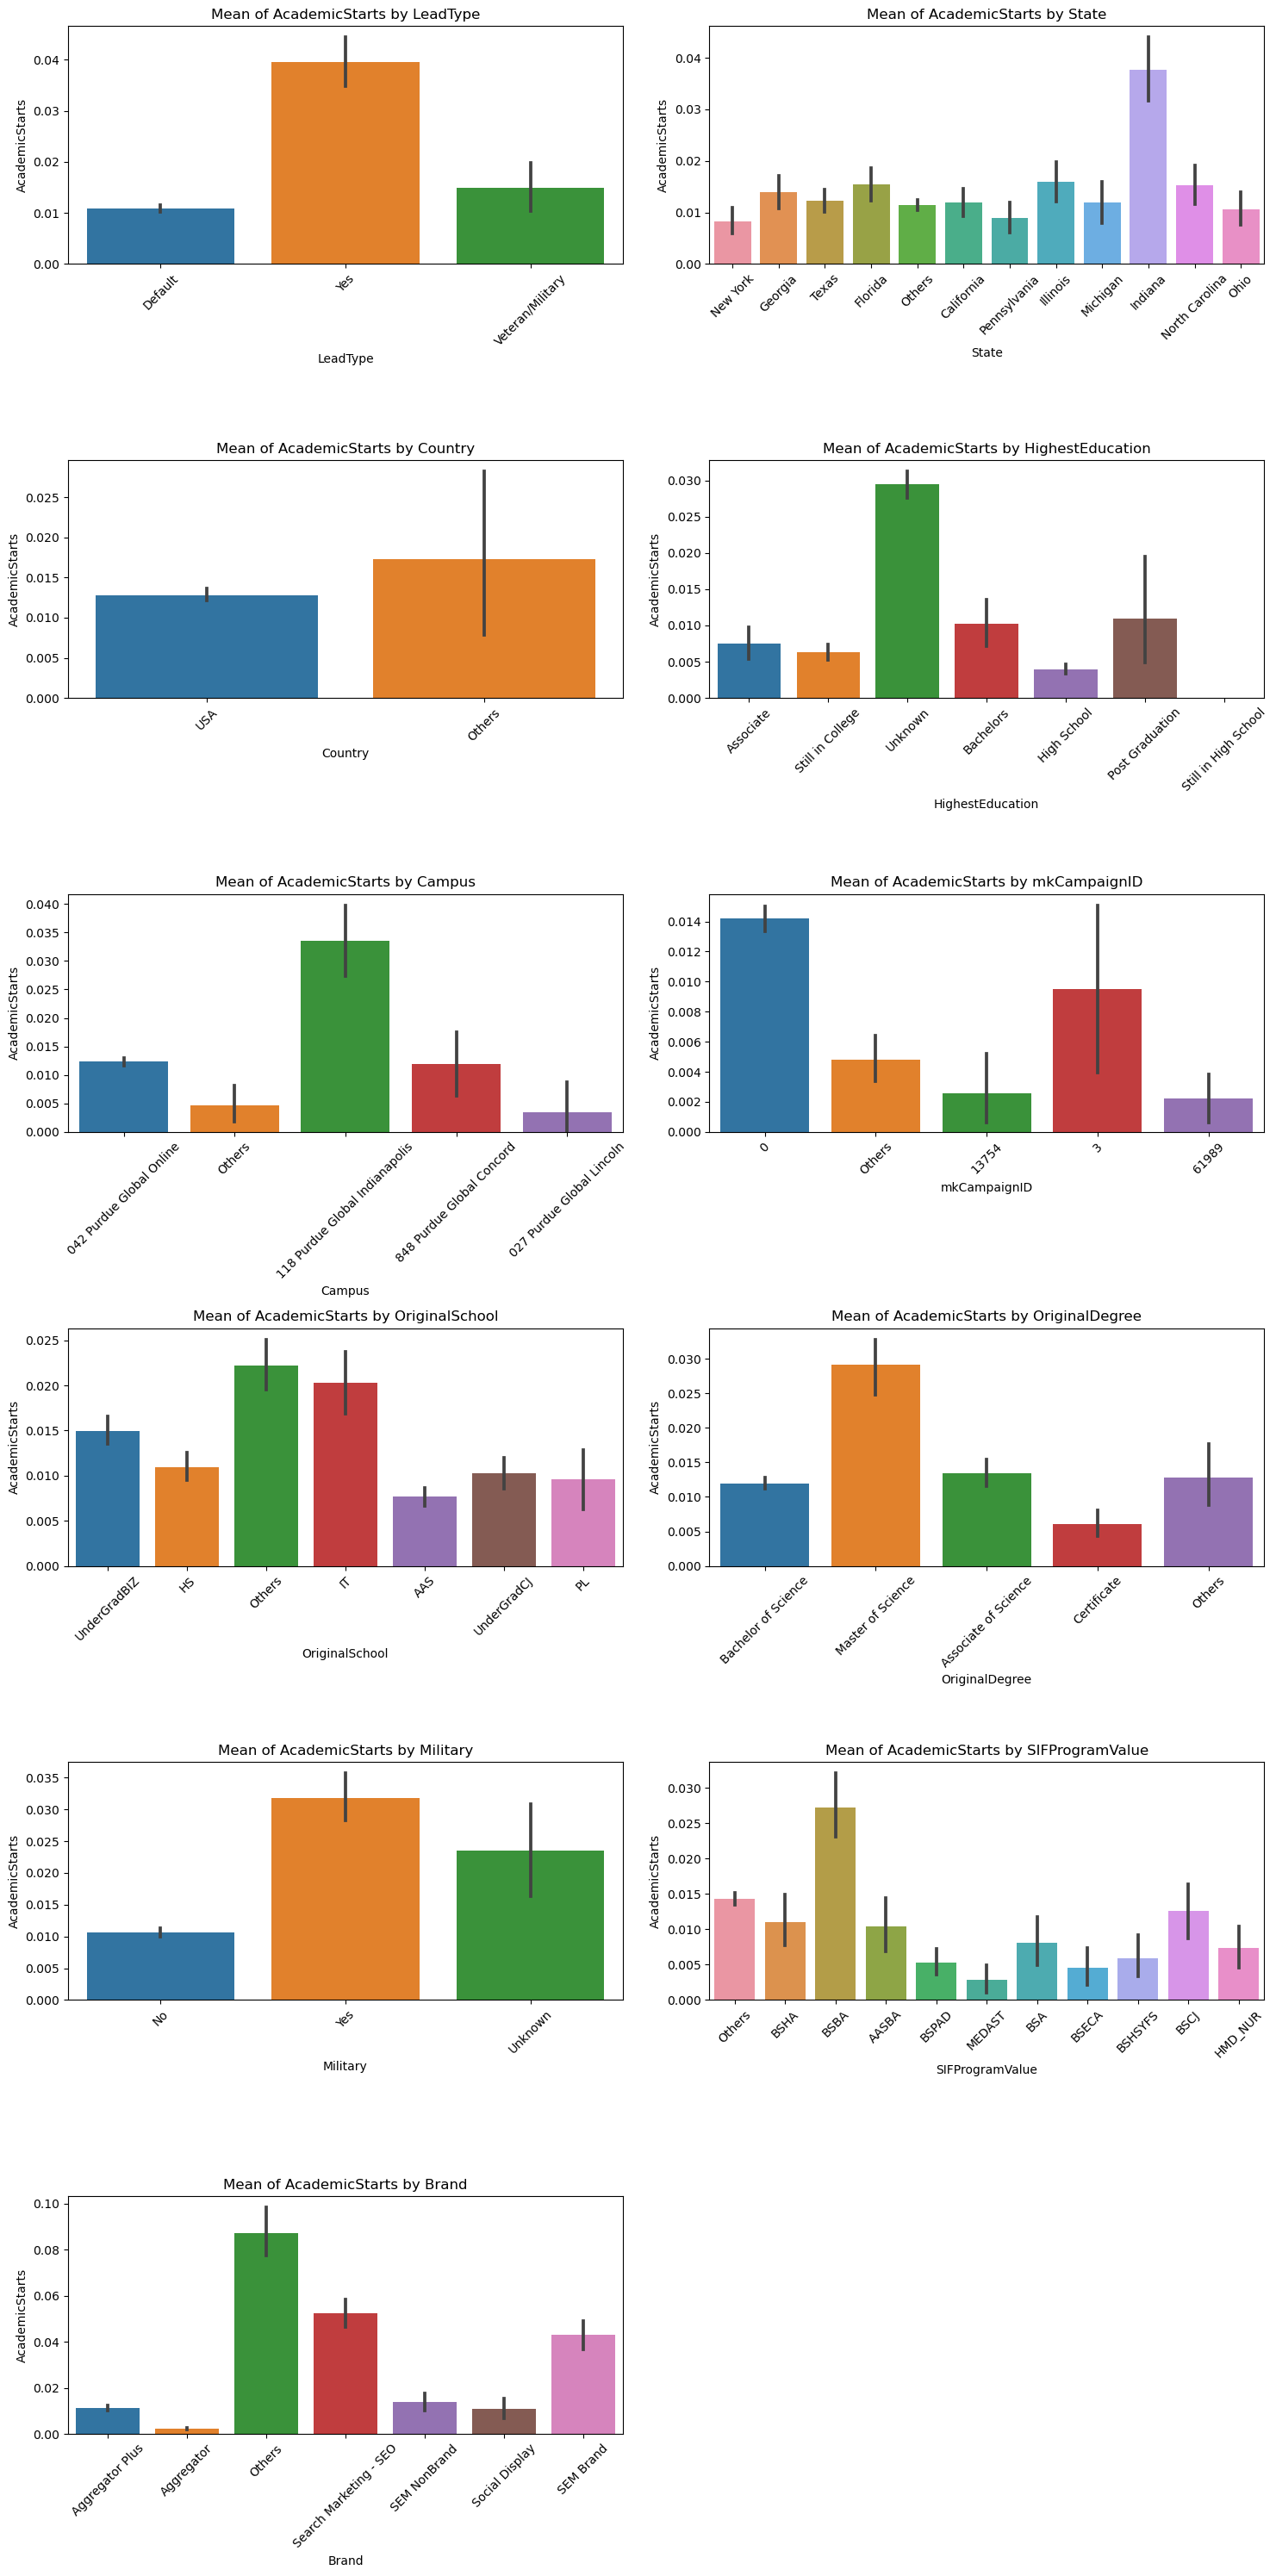

In [94]:
num_features = len(feature_columns)
num_cols = 2
num_rows = (num_features + num_cols - 1) // num_cols  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  

for i, col in enumerate(feature_columns):
    sns.barplot(x=col, y='AcademicStarts', data=leads_data, estimator='mean', ax=axes[i])
    axes[i].set_title(f'Mean of AcademicStarts by {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Observations:

##### Leads labeled as 'Yes' in LeadType are more likely to lead to academic starts.
##### States like Indiana and Illinois, North Carolina have a greater propensity for converting
##### People who are'Bachelors' or 'Post Graduates' are more likely to enrol or continue education
##### The '118 Purdue Global Indianapolis' campus has a more engaged or higher converting lead pool compared to other campuses.
##### Individuals with 'Master of Science' degree are more inclined towards further academic pursuits
##### Leads with Military affiliation might correlate with a slightly higher interest in academic programs


### Correlation Matrix

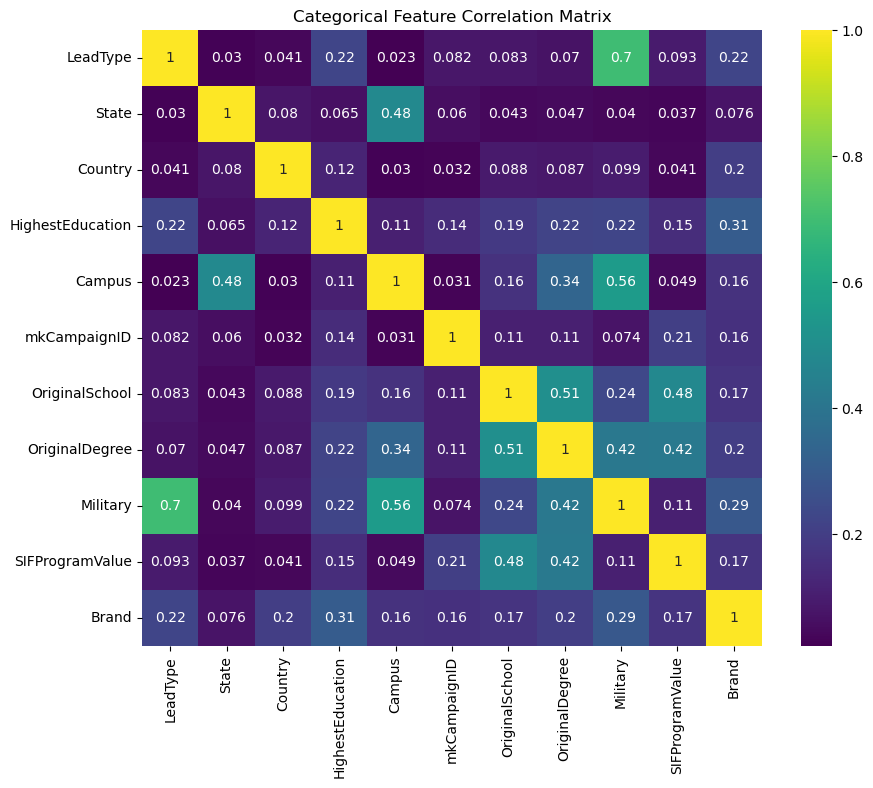

In [96]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = sum(confusion_matrix.sum())
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

categorical_corr = pd.DataFrame(index=feature_columns, columns=feature_columns)

for col1 in feature_columns:
    for col2 in feature_columns:
        categorical_corr.loc[col1, col2] = cramers_v(leads_data[col1], leads_data[col2])

plt.figure(figsize=(10, 8))
sns.heatmap(categorical_corr.astype(float), annot=True, cmap='viridis')
plt.title('Categorical Feature Correlation Matrix')
plt.show()


#### Observations
##### Features with high correlation with each other: Military & LeadType, OriginalDegree & OriginalSchool, Campus & Military, Campus & State
##### HighestEducation and OriginalDegree (0.42): This moderate correlation might suggest that the highest level of education achieved by the lead is related to the type of degree they are interested in or have completed
##### State, Country & mkCampaignID show low correlation with almost all other features 

## Feature Engineering

### Train Test Split (Stratified because of class imbalance)

In [99]:
X = leads_data.drop('AcademicStarts', axis =1)
y = leads_data['AcademicStarts']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

In [101]:
X_train.head()

,LeadType,mkCampaignID,State,Country,HighestEducation,Campus,OriginalSchool,OriginalDegree,Military,SIFProgramValue,Brand
48850,Default,0,Others,USA,High School,042 Purdue Globa...,IT,Bachelor of Science,No,Others,Aggregator
93053,Default,0,Pennsylvania,USA,High School,042 Purdue Globa...,UnderGradCJ,Bachelor of Science,No,Others,Aggregator Plus
93415,Default,0,Others,USA,High School,042 Purdue Globa...,UnderGradBIZ,Bachelor of Science,No,BSBA,Aggregator
81437,Default,61989,Others,USA,Still in College,042 Purdue Globa...,HS,Bachelor of Science,No,Others,Aggregator
30758,Default,0,Others,USA,Unknown,042 Purdue Globa...,Others,Bachelor of Science,No,Others,Aggregator


In [102]:
y_train.head()

48850    0
93053    0
93415    0
81437    0
30758    0
Name: AcademicStarts, dtype: int64

### One Hot Encoding

In [105]:
# values of mkCampaignID are in number format, so converting those to strings 
X_train['mkCampaignID'] = X_train['mkCampaignID'].astype(str)
X_test['mkCampaignID'] = X_test['mkCampaignID'].astype(str)

In [106]:
X_train.head()

,LeadType,mkCampaignID,State,Country,HighestEducation,Campus,OriginalSchool,OriginalDegree,Military,SIFProgramValue,Brand
48850,Default,0,Others,USA,High School,042 Purdue Globa...,IT,Bachelor of Science,No,Others,Aggregator
93053,Default,0,Pennsylvania,USA,High School,042 Purdue Globa...,UnderGradCJ,Bachelor of Science,No,Others,Aggregator Plus
93415,Default,0,Others,USA,High School,042 Purdue Globa...,UnderGradBIZ,Bachelor of Science,No,BSBA,Aggregator
81437,Default,61989,Others,USA,Still in College,042 Purdue Globa...,HS,Bachelor of Science,No,Others,Aggregator
30758,Default,0,Others,USA,Unknown,042 Purdue Globa...,Others,Bachelor of Science,No,Others,Aggregator


In [107]:
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded = one_hot_encoder.fit_transform(X_train)

# Only applying transformation to the test data
X_test_encoded = one_hot_encoder.transform(X_test)

In [108]:
X_train_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [109]:
# Converting these arrays back to DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=one_hot_encoder.get_feature_names_out())
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=one_hot_encoder.get_feature_names_out())

In [110]:
X_test_encoded_df = X_test_encoded_df.reindex(columns=X_train_encoded_df.columns, fill_value=0)

In [111]:
print(X_train_encoded_df.shape)
print(X_test_encoded_df.shape)

(73423, 56)
(24475, 56)


### Handle Imbalanced Classes

#### Under-sampling Tomek Links

In [114]:
tomek_links = TomekLinks()
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_train_encoded_df, y_train)


In [115]:
print("Class distribution after Tomek Links re-sampling:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

Class distribution after Tomek Links re-sampling:
0    0.987142
1    0.012858
Name: AcademicStarts, dtype: float64


##### Class imbalance still exists. So we combine Tomek Links with SMOTE

In [117]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_train_resampled_2, y_train_resampled_2 = smote_tomek.fit_resample(X_train_encoded_df, y_train)

In [118]:
print("Class distribution after SMOTETomek re-sampling:")
print(pd.Series(y_train_resampled_2).value_counts(normalize=True))

Class distribution after SMOTETomek re-sampling:
0    0.5
1    0.5
Name: AcademicStarts, dtype: float64


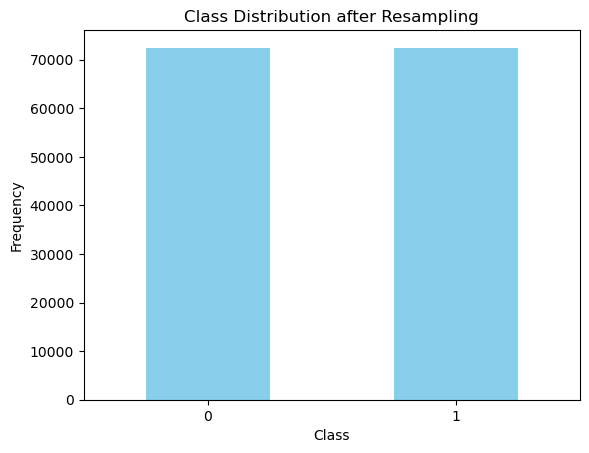

In [119]:
# Bar graph for the above 
Class_dist = y_train_resampled_2.value_counts()
Class_dist.plot(kind='bar', color='skyblue')
plt.title('Class Distribution after Resampling')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


## Evaluation Metrics

In [267]:
#Initialize evaluation matrix
algorithms = ["LogReg", "RandomForest","XGBoost"]
eval_metrics = ["Accuracy","AUC-ROC", "Precision", "Recall", "F1Score"]

train_perf_clfn = pd.DataFrame(columns = algorithms, index=eval_metrics)
test_perf_clfn = pd.DataFrame(columns = algorithms, index=eval_metrics)

In [269]:
#Evaluation helper function
def get_evaluation_metrics_clfn(y_true, y_pred):
    
    #Evaluate the model using Accuracy
    accuracy = np.round(accuracy_score(y_true, y_pred),3)
    
    #Evaluate the model using AUC
    roc_auc = np.round(roc_auc_score(y_true, y_pred),3)
    
    #Evaluate the model using Precision
    precision = np.round(precision_score(y_true, y_pred),3)
    
    #Evaluate the model using Recall
    recall = np.round(recall_score(y_true, y_pred),3)
    
    #Evaluate the model using F1 Score
    f1score = np.round(f1_score(y_true, y_pred),3)

    return((accuracy, roc_auc, precision, recall, f1score))

## Algorithms

### Logistic Regression

In [402]:
# Inititalizing and fitting the model
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_resampled_2, y_train_resampled_2)

LogisticRegression(random_state=42, solver='liblinear')

In [403]:
# Getting Predictions
y_fit1 = log_reg.predict(X_train_resampled_2)
y_pred1 = log_reg.predict(X_test_encoded_df)
print(classification_report(y_test, y_pred1))


              precision    recall  f1-score   support

           0       1.00      0.77      0.87     24160
           1       0.04      0.70      0.07       315

    accuracy                           0.77     24475
   macro avg       0.52      0.74      0.47     24475
weighted avg       0.98      0.77      0.86     24475



In [404]:
#Evaluate the Model
train_perf_clfn["LogReg"] = get_evaluation_metrics_clfn(y_train_resampled_2,y_fit1)
test_perf_clfn["LogReg"] = get_evaluation_metrics_clfn(y_test,y_pred1)

In [405]:
train_perf_clfn

,LogReg,RandomForest,XGBoost
Accuracy,0.772,0.772,0.772
AUC-ROC,0.772,0.772,0.772
Precision,0.773,0.773,0.773
Recall,0.771,0.771,0.771
F1Score,0.772,0.772,0.772


In [406]:
test_perf_clfn

,LogReg,RandomForest,XGBoost
Accuracy,0.773,0.773,0.852
AUC-ROC,0.739,0.739,0.716
Precision,0.039,0.039,0.049
Recall,0.705,0.705,0.578
F1Score,0.074,0.074,0.091


### Random Forest Classifier

In [411]:
# Inititalizing and fitting the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_resampled_2, y_train_resampled_2)

RandomForestClassifier(random_state=42)

In [414]:
# Getting Predictions
y_fit2 = rf_classifier.predict(X_train_resampled_2)
y_pred2 = rf_classifier.predict(X_test_encoded_df)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     24160
           1       0.07      0.22      0.11       315

    accuracy                           0.95     24475
   macro avg       0.53      0.59      0.54     24475
weighted avg       0.98      0.95      0.96     24475



In [415]:
#Evaluate the Model
train_perf_clfn["RandomForest"] = get_evaluation_metrics_clfn(y_train_resampled_2,y_fit2)
test_perf_clfn["RandomForest"] = get_evaluation_metrics_clfn(y_test,y_pred2)

In [416]:
train_perf_clfn

,LogReg,RandomForest,XGBoost
Accuracy,0.772,0.969,0.772
AUC-ROC,0.772,0.969,0.772
Precision,0.773,0.963,0.773
Recall,0.771,0.976,0.771
F1Score,0.772,0.970,0.772


In [417]:
test_perf_clfn

,LogReg,RandomForest,XGBoost
Accuracy,0.773,0.953,0.852
AUC-ROC,0.739,0.592,0.716
Precision,0.039,0.072,0.049
Recall,0.705,0.222,0.578
F1Score,0.074,0.109,0.091


### XGBoost

In [419]:
#Initialize and fit the model
xgbclass = XGBClassifier(n_estimators = 10, random_state = 0)
xgbclass.fit(X_train_resampled_2, y_train_resampled_2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [420]:
# Getting Predictions
y_fit3 = xgbclass.predict(X_train_resampled_2)
y_pred3 = xgbclass.predict(X_test_encoded_df)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87     24160
           1       0.04      0.70      0.07       315

    accuracy                           0.77     24475
   macro avg       0.52      0.74      0.47     24475
weighted avg       0.98      0.77      0.86     24475



In [421]:
#Evaluate the Model
train_perf_clfn["XGBoost"] = get_evaluation_metrics_clfn(y_train_resampled_2,y_fit3)
test_perf_clfn["XGBoost"] = get_evaluation_metrics_clfn(y_test,y_pred3)

In [422]:
train_perf_clfn

,LogReg,RandomForest,XGBoost
Accuracy,0.772,0.969,0.877
AUC-ROC,0.772,0.969,0.877
Precision,0.773,0.963,0.863
Recall,0.771,0.976,0.897
F1Score,0.772,0.970,0.880


In [423]:
test_perf_clfn

,LogReg,RandomForest,XGBoost
Accuracy,0.773,0.953,0.852
AUC-ROC,0.739,0.592,0.716
Precision,0.039,0.072,0.049
Recall,0.705,0.222,0.578
F1Score,0.074,0.109,0.091


### Creating AUC-ROC Curve for Logistic Regression

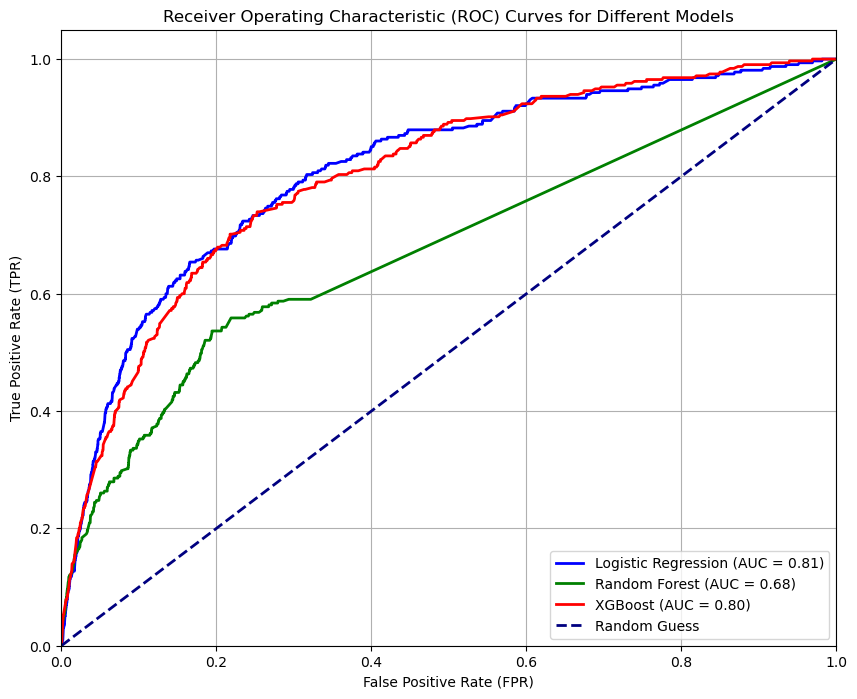

In [434]:
#Logistic Regression Probabilities
y_prob_log_reg = log_reg.predict_proba(X_test_encoded_df)[:, 1]

# Random Forest Probabilities
y_prob_rf = rf_classifier.predict_proba(X_test_encoded_df)[:, 1]

# Train XGBoost
y_prob_xgb = xgbclass.predict_proba(X_test_encoded_df)[:, 1]

# Compute ROC curve and AUC for each model
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_prob_log_reg)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves for Different Models')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Hyperparameter Tuning - Logistic Regression

In [140]:
# Set up evaluation Matrix for hyperparameters
iterations = ["LogReg1", "LogReg2", "LogReg3", "LogReg4"]
eval_metrics = ["Accuracy","AUC-ROC", "Precision", "Recall", "F1Score"]

train_perf_clfn_hyp_tun = pd.DataFrame(columns = iterations, index=eval_metrics)
test_perf_clfn_hyp_tun = pd.DataFrame(columns = iterations, index=eval_metrics)


In [141]:
#Initialize and fit the model
LogReg1 = LogisticRegression(solver='liblinear', random_state=42)
LogReg1.fit(X_train_resampled_2, y_train_resampled_2)

# Getting Predictions
y_fit = LogReg1.predict(X_train_resampled_2)
y_pred = LogReg1.predict(X_test_encoded_df)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87     24160
           1       0.04      0.72      0.08       315

    accuracy                           0.77     24475
   macro avg       0.52      0.75      0.47     24475
weighted avg       0.98      0.77      0.86     24475



In [142]:
LogReg1.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [143]:
#Evaluate the Model
train_perf_clfn_hyp_tun["LogReg1"] = get_evaluation_metrics_clfn(y_train_resampled_2,y_fit)
test_perf_clfn_hyp_tun["LogReg1"] = get_evaluation_metrics_clfn(y_test,y_pred)

In [144]:
train_perf_clfn_hyp_tun

,LogReg1,LogReg2,LogReg3,LogReg4
Accuracy,0.774,NaN,NaN,NaN
AUC-ROC,0.774,NaN,NaN,NaN
Precision,0.774,NaN,NaN,NaN
Recall,0.774,NaN,NaN,NaN
F1Score,0.774,NaN,NaN,NaN


In [145]:
test_perf_clfn_hyp_tun

,LogReg1,LogReg2,LogReg3,LogReg4
Accuracy,0.773,NaN,NaN,NaN
AUC-ROC,0.745,NaN,NaN,NaN
Precision,0.040,NaN,NaN,NaN
Recall,0.717,NaN,NaN,NaN
F1Score,0.075,NaN,NaN,NaN


#### Feature Importances

In [146]:
#Feature importance dataframe
feature_importance = pd.DataFrame({'Feature': X_train_resampled_2.columns,'Importance': LogReg1.coef_[0]})

# Display the feature importance sorted by absolute value
feature_importance['Absolute Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Importance', ascending=False).reset_index()
print(feature_importance[['Feature', 'Importance']])

                Feature  Importance
0          Brand_Others    3.562750
1          LeadType_Yes    3.146853
2          Military_Yes   -2.810752
3   Brand_Search Mar...    2.789522
4       Brand_SEM Brand    2.590082
5   LeadType_Veteran...    2.463730
6   SIFProgramValue_...   -1.819468
7           Country_USA    1.758715
8   OriginalSchool_O...   -1.737983
9   Brand_Aggregator...    1.444961
10   Brand_SEM NonBrand    1.437371
11    OriginalSchool_PL   -1.188152
12  HighestEducation...   -1.081795
13  OriginalDegree_C...   -1.060021
14  Campus_042 Purdu...    0.995981
15  OriginalDegree_M...    0.982406
16  Campus_118 Purdu...    0.923590
17  SIFProgramValue_...   -0.913395
18  Campus_848 Purdu...    0.869946
19        Campus_Others   -0.864822
20  SIFProgramValue_...   -0.830585
21       State_Michigan   -0.813033
22  OriginalSchool_U...   -0.771457
23  SIFProgramValue_...    0.744267
24  Brand_Social Dis...    0.709925
25       State_New York   -0.655179
26  OriginalSchool_U...   -0

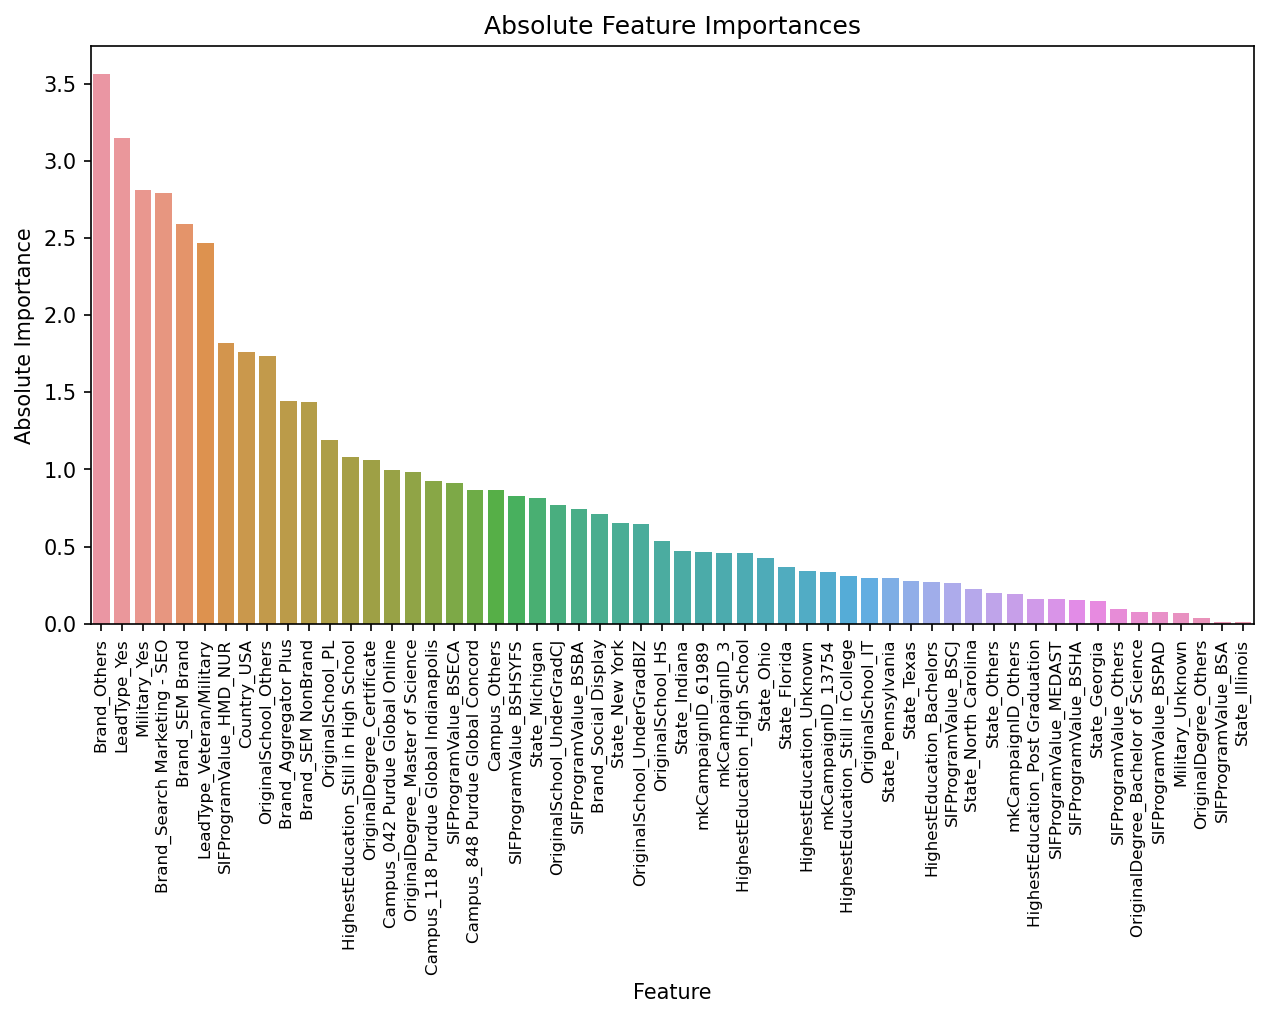

In [147]:
plt.figure(figsize=(10,5),dpi=150)
sns.barplot(data = feature_importance,x = 'Feature',y ='Absolute Importance')
plt.xticks(rotation=90, fontsize=8)
plt.title("Absolute Feature Importances")
plt.show()

#### Hypertuning 'C', 'max_iter', 'solver'

In [149]:
# Iteration 2
C = [int(x) for x in np.linspace(100,1000, 5)]
max_iter = [int(x) for x in np.linspace(200, 500, 5)]

param_grid2 = {'C':C,
               'max_iter': max_iter,
                'solver': ['sag','lbfgs', 'liblinear','newton-cg', 'saga'] }


In [150]:
log_reg2 = LogisticRegression(random_state=42)

grid_search2 = GridSearchCV(estimator=log_reg2, param_grid=param_grid2, 
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=8)

In [151]:
# Fit GridSearchCV on the training data
grid_search2.fit(X_train_resampled_2, y_train_resampled_2)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [100, 325, 550, 775, 1000],
                         'max_iter': [200, 275, 350, 425, 500],
                         'solver': ['sag', 'lbfgs', 'liblinear', 'newton-cg',
                                    'saga']},
             scoring='roc_auc', verbose=8)

In [152]:
# Find best parameters and best score
grid_search2.best_params_, grid_search2.best_score_

({'C': 550, 'max_iter': 200, 'solver': 'liblinear'}, 0.849509032947519)

In [188]:
grid_search2.cv_results_

{'mean_fit_time': array([44.3407372 ,  5.38865471,  3.54858336,  3.28412066, 41.13584604,
        38.08209739,  1.75340371,  2.54207573,  2.63843689, 58.96647339,
        39.16646476,  2.83548007,  5.14598355,  3.88876953, 60.48489981,
        34.41237426,  2.25157475,  4.12822824,  3.49683452, 61.15999694,
        33.94810128,  1.74201818,  3.92611289,  3.32448573, 60.92784429,
        35.94530873,  1.93078551,  3.84148602,  3.82152624, 36.96889286,
        52.1145215 ,  2.56284332,  3.11436067,  3.36570163, 51.4371686 ,
        61.91991954,  1.7821156 ,  2.84877024,  3.20027041, 66.51699085,
        65.45542145,  2.00989361,  2.62315545,  2.57101607, 82.53435946,
        64.60727906,  1.96925111,  2.7110302 ,  2.8252037 , 95.99304385,
        35.28631878,  1.64954433,  2.63840685,  3.4977396 , 37.36690607,
        52.2992569 ,  2.63356662,  3.37718925,  3.40653882, 50.44172959,
        65.09977131,  2.48044343,  3.19391088,  3.2604341 , 66.02225842,
        77.40906224,  1.77333851, 

In [153]:
# Iteration 3
C = [int(x) for x in range(450,650,25)]
max_iter = [int(x) for x in range(50,200,15)]

param_grid3 = {'C':C,
               'max_iter': max_iter,
                }

log_reg3 = LogisticRegression(random_state=42,solver='liblinear')
grid_search3 = GridSearchCV(estimator=log_reg3, param_grid=param_grid3, 
                           cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)

grid_search3.fit(X_train_resampled_2, y_train_resampled_2)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [450, 475, 500, 525, 550, 575, 600, 625],
                         'max_iter': [50, 65, 80, 95, 110, 125, 140, 155, 170,
                                      185]},
             scoring='roc_auc', verbose=2)

In [190]:
# Find best parameters and best score
grid_search3.cv_results_, grid_search3.best_params_, grid_search3.best_score_

({'mean_fit_time': array([5.43839343, 4.62115963, 5.11067096, 5.06238015, 5.13078825,
         5.01457675, 5.03666663, 5.21541643, 5.0883259 , 5.07402786,
         4.8923471 , 4.91662995, 4.97121247, 4.93658431, 4.88825941,
         4.92476519, 4.85449441, 4.84887473, 4.93718092, 4.82584786,
         5.03118833, 5.05304853, 5.00637817, 5.09334103, 4.97648621,
         4.98930573, 5.00909551, 4.97157605, 5.04688255, 5.03099839,
         5.00861748, 5.04256964, 5.02052347, 5.03214685, 5.0433143 ,
         5.01200636, 5.02838429, 5.04748837, 5.04167032, 5.08947849,
         4.84155321, 4.91011333, 4.75078313, 4.93271748, 4.88588635,
         4.89188162, 4.82698441, 4.86863414, 4.83215968, 4.83183932,
         4.99463971, 5.05750187, 5.01622176, 5.02969662, 5.0511477 ,
         5.04610173, 5.00662676, 5.0477612 , 4.99510662, 5.05985133,
         4.86469436, 4.8976961 , 4.84997368, 4.90822617, 4.78372622,
         4.90901407, 4.91433024, 4.85305429, 4.89583111, 4.82172457,
         4.946114

In [155]:
# Iteration 4
max_iter = [int(x) for x in range(30,55,5)]
param_grid4 = {'max_iter': max_iter }

log_reg4 = LogisticRegression(random_state=42,solver='liblinear', C=525)
grid_search4 = GridSearchCV(estimator=log_reg4, param_grid=param_grid4, 
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

grid_search4.fit(X_train_resampled_2, y_train_resampled_2)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(C=525, random_state=42,
                                          solver='liblinear'),
             n_jobs=-1, param_grid={'max_iter': [30, 35, 40, 45, 50]},
             scoring='roc_auc', verbose=2)

In [192]:
# Find best parameters and best score
grid_search4.cv_results_, grid_search4.best_params_, grid_search4.best_score_

({'mean_fit_time': array([6.39885268, 6.52041283, 6.84003348, 6.49732952, 5.61408567]),
  'std_fit_time': array([0.23205799, 0.72517638, 0.93278731, 0.47253913, 1.03244875]),
  'mean_score_time': array([0.04136672, 0.04326367, 0.03766127, 0.04591718, 0.03076606]),
  'std_score_time': array([0.00484967, 0.00608743, 0.01262191, 0.01031578, 0.01195117]),
  'param_max_iter': masked_array(data=[30, 35, 40, 45, 50],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_iter': 30},
   {'max_iter': 35},
   {'max_iter': 40},
   {'max_iter': 45},
   {'max_iter': 50}],
  'split0_test_score': array([0.84773042, 0.84773042, 0.84773042, 0.84773042, 0.84773042]),
  'split1_test_score': array([0.849118, 0.849118, 0.849118, 0.849118, 0.849118]),
  'split2_test_score': array([0.85246195, 0.85246195, 0.85246195, 0.85246195, 0.85246195]),
  'split3_test_score': array([0.84811395, 0.84811395, 0.84811395, 0.84811395, 0.84811395]),
 

In [157]:
#Initialize and fit the model
LogReg2 = LogisticRegression(random_state=42,solver='liblinear', C=525,max_iter=30)
LogReg2.fit(X_train_resampled_2, y_train_resampled_2)

# Getting Predictions
y_fit = LogReg2.predict(X_train_resampled_2)
y_pred = LogReg2.predict(X_test_encoded_df)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87     24160
           1       0.04      0.72      0.08       315

    accuracy                           0.77     24475
   macro avg       0.52      0.75      0.47     24475
weighted avg       0.98      0.77      0.86     24475



In [158]:
#Evaluate the Model
train_perf_clfn_hyp_tun["LogReg2"] = get_evaluation_metrics_clfn(y_train_resampled_2,y_fit)
test_perf_clfn_hyp_tun["LogReg2"] = get_evaluation_metrics_clfn(y_test,y_pred)

In [159]:
train_perf_clfn_hyp_tun

,LogReg1,LogReg2,LogReg3,LogReg4
Accuracy,0.774,0.774,NaN,NaN
AUC-ROC,0.774,0.774,NaN,NaN
Precision,0.774,0.774,NaN,NaN
Recall,0.774,0.774,NaN,NaN
F1Score,0.774,0.774,NaN,NaN


In [160]:
test_perf_clfn_hyp_tun

,LogReg1,LogReg2,LogReg3,LogReg4
Accuracy,0.773,0.773,NaN,NaN
AUC-ROC,0.745,0.745,NaN,NaN
Precision,0.040,0.040,NaN,NaN
Recall,0.717,0.717,NaN,NaN
F1Score,0.075,0.075,NaN,NaN


In [161]:
# Feature importance dataframe
feature_importance = pd.DataFrame({'Feature': X_train_resampled_2.columns,'Importance': LogReg2.coef_[0]})

# Display the feature importance sorted by absolute value
feature_importance['Absolute Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Importance', ascending=False).reset_index()
print(feature_importance[['Feature', 'Importance']])

                Feature  Importance
0          LeadType_Yes    6.734879
1          Military_Yes   -6.398706
2   LeadType_Veteran...    6.053997
3   HighestEducation...   -4.982342
4          Brand_Others    3.571809
5   Brand_Search Mar...    2.800131
6       Brand_SEM Brand    2.599295
7   SIFProgramValue_...   -1.826789
8           Country_USA    1.794021
9   OriginalSchool_O...   -1.750211
10  Brand_Aggregator...    1.451235
11   Brand_SEM NonBrand    1.446696
12    OriginalSchool_PL   -1.193263
13  Campus_042 Purdu...    1.077843
14  OriginalDegree_C...   -1.062916
15  Campus_118 Purdu...    1.010208
16  OriginalDegree_M...    0.991816
17  Campus_848 Purdu...    0.955989
18  SIFProgramValue_...   -0.919630
19  SIFProgramValue_...   -0.837041
20       State_Michigan   -0.814911
21        Campus_Others   -0.790446
22  OriginalSchool_U...   -0.774698
23  SIFProgramValue_...    0.744253
24  Brand_Social Dis...    0.718137
25       State_New York   -0.654866
26  OriginalSchool_U...   -0

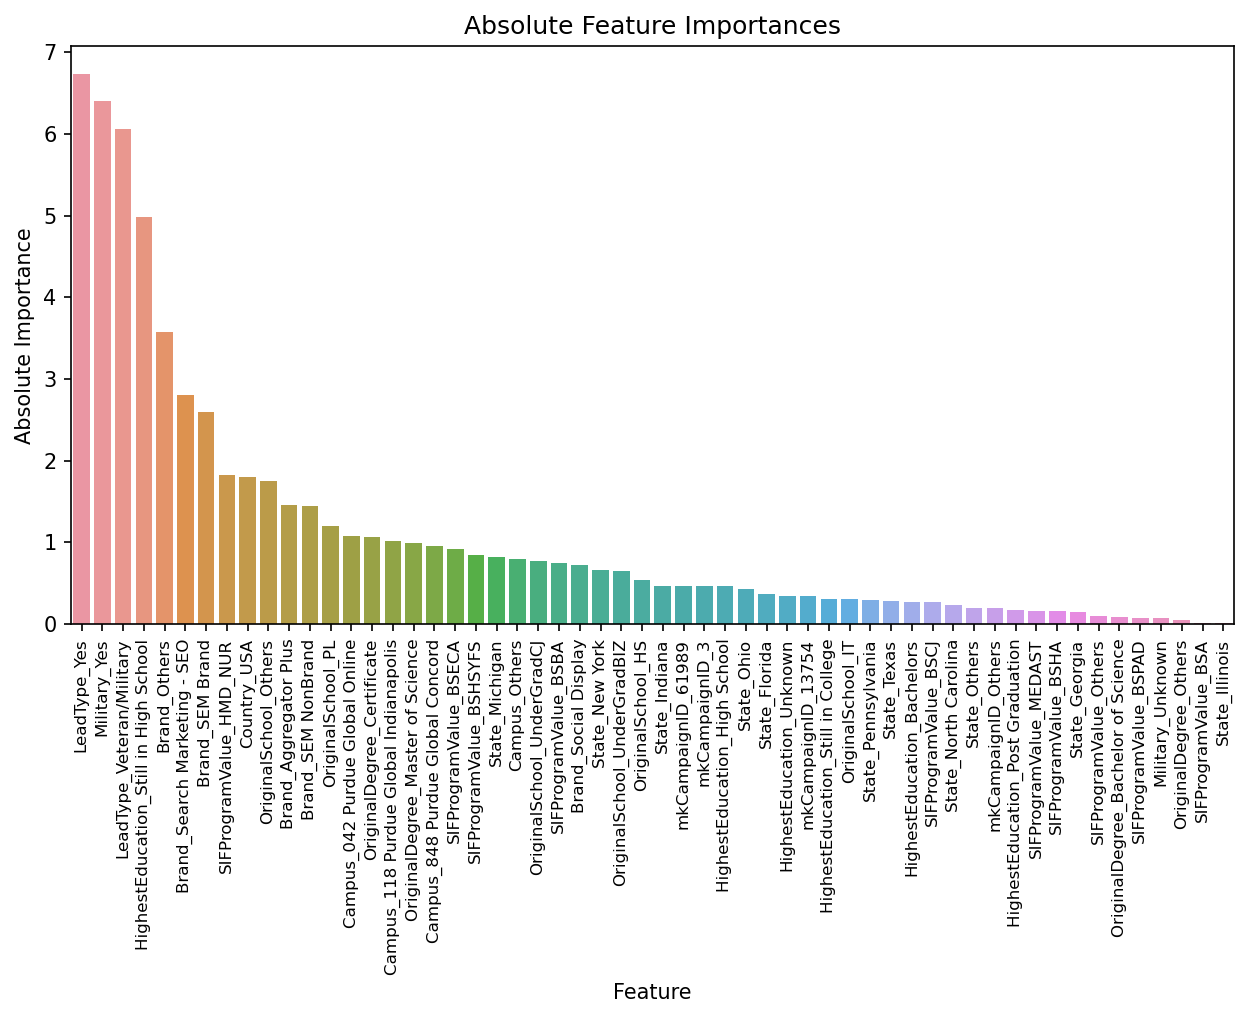

In [162]:
plt.figure(figsize=(10,5),dpi=150)
sns.barplot(data = feature_importance,x = 'Feature',y ='Absolute Importance')
plt.xticks(rotation=90, fontsize=8)
plt.title("Absolute Feature Importances")
plt.show()

#### Hypertuning 'class_weight', 'tol', 'penalty'

In [164]:
# Iteration 5

param_grid5 = {
                'class_weight': ['balanced',None],
                'tol': [0.00001, 0.0001,0.001],
                'penalty':['l2','l1','elasticnet', None]
}

log_reg5 = LogisticRegression(random_state=42,solver='liblinear', C=525,max_iter=30)
grid_search5 = GridSearchCV(estimator=log_reg5, param_grid=param_grid5, 
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

grid_search5.fit(X_train_resampled_2, y_train_resampled_2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\kharb\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kharb\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kharb\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kharb\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver = 

GridSearchCV(cv=5,
             estimator=LogisticRegression(C=525, max_iter=30, random_state=42,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'penalty': ['l2', 'l1', 'elasticnet', None],
                         'tol': [1e-05, 0.0001, 0.001]},
             scoring='roc_auc', verbose=2)

In [194]:
# Find best parameters and best score
grid_search5.cv_results_, grid_search5.best_params_, grid_search5.best_score_

({'mean_fit_time': array([8.65686693e+00, 6.30536346e+00, 3.80306802e+00, 1.05814056e+02,
         1.04007885e+02, 8.04011082e+01, 2.31230021e-01, 2.48210621e-01,
         2.43542528e-01, 2.48153162e-01, 2.36980486e-01, 2.51461267e-01,
         8.84573016e+00, 6.04515872e+00, 3.79668946e+00, 1.92631157e+04,
         1.15966708e+04, 7.32644181e+01, 2.86177635e-01, 2.56646633e-01,
         2.46243429e-01, 2.19367695e-01, 1.88035345e-01, 1.80401373e-01]),
  'std_fit_time': array([2.23331778e-01, 2.06014897e-01, 2.10978505e-01, 2.60795001e+01,
         2.65425899e+01, 4.42400188e+00, 6.07530904e-03, 1.11717934e-02,
         1.00625959e-02, 6.43276318e-03, 6.99740074e-03, 1.77516534e-02,
         9.99126600e-01, 2.28558717e-01, 1.26228728e-01, 2.47906275e+01,
         9.39778420e+03, 1.91388500e+01, 6.92117806e-02, 5.33521971e-02,
         2.77865851e-02, 1.85466032e-02, 2.52808791e-02, 2.24717796e-02]),
  'mean_score_time': array([0.03751779, 0.04585857, 0.05181155, 0.06389132, 0.0674314 ,

In [166]:
#Initialize and fit the model
LogReg3 = LogisticRegression(random_state=42,solver='liblinear', C=525,max_iter=30, class_weight=None, penalty = 'l1',tol= 1e-05 )
LogReg3.fit(X_train_resampled_2, y_train_resampled_2)

# Get Predictions
y_fit = LogReg3.predict(X_train_resampled_2)
y_pred = LogReg3.predict(X_test_encoded_df)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87     24160
           1       0.04      0.72      0.08       315

    accuracy                           0.77     24475
   macro avg       0.52      0.75      0.47     24475
weighted avg       0.98      0.77      0.86     24475



C:\Users\kharb\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [167]:
#Evaluate the Model
train_perf_clfn_hyp_tun["LogReg3"] = get_evaluation_metrics_clfn(y_train_resampled_2,y_fit)
test_perf_clfn_hyp_tun["LogReg3"] = get_evaluation_metrics_clfn(y_test,y_pred)

In [168]:
train_perf_clfn_hyp_tun

,LogReg1,LogReg2,LogReg3,LogReg4
Accuracy,0.774,0.774,0.774,NaN
AUC-ROC,0.774,0.774,0.774,NaN
Precision,0.774,0.774,0.774,NaN
Recall,0.774,0.774,0.774,NaN
F1Score,0.774,0.774,0.774,NaN


In [169]:
test_perf_clfn_hyp_tun

,LogReg1,LogReg2,LogReg3,LogReg4
Accuracy,0.773,0.773,0.773,NaN
AUC-ROC,0.745,0.745,0.745,NaN
Precision,0.040,0.040,0.040,NaN
Recall,0.717,0.717,0.717,NaN
F1Score,0.075,0.075,0.075,NaN


In [170]:
# Feature importance dataframe
feature_importance = pd.DataFrame({'Feature': X_train_resampled_2.columns,'Importance': LogReg3.coef_[0]})

# Display the feature importance sorted by absolute value
feature_importance['Absolute Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Importance', ascending=False).reset_index()
print(feature_importance[['Feature', 'Importance']])

                Feature  Importance
0   HighestEducation...   -8.975456
1          LeadType_Yes    4.274231
2          Military_Yes   -3.937717
3   LeadType_Veteran...    3.593215
4          Brand_Others    3.571324
5   Brand_Search Mar...    2.797755
6       Brand_SEM Brand    2.598422
7   SIFProgramValue_...   -1.837077
8           Country_USA    1.752130
9   OriginalSchool_O...   -1.752115
10  Brand_Aggregator...    1.449883
11   Brand_SEM NonBrand    1.446170
12    OriginalSchool_PL   -1.194944
13  OriginalDegree_C...   -1.063784
14  OriginalDegree_M...    0.991090
15  Campus_042 Purdu...    0.946937
16  SIFProgramValue_...   -0.933231
17        Campus_Others   -0.920431
18  Campus_118 Purdu...    0.879522
19  SIFProgramValue_...   -0.850015
20  Campus_848 Purdu...    0.828817
21       State_Michigan   -0.819380
22  OriginalSchool_U...   -0.777385
23  SIFProgramValue_...    0.735258
24  Brand_Social Dis...    0.717525
25       State_New York   -0.660180
26  OriginalSchool_U...   -0

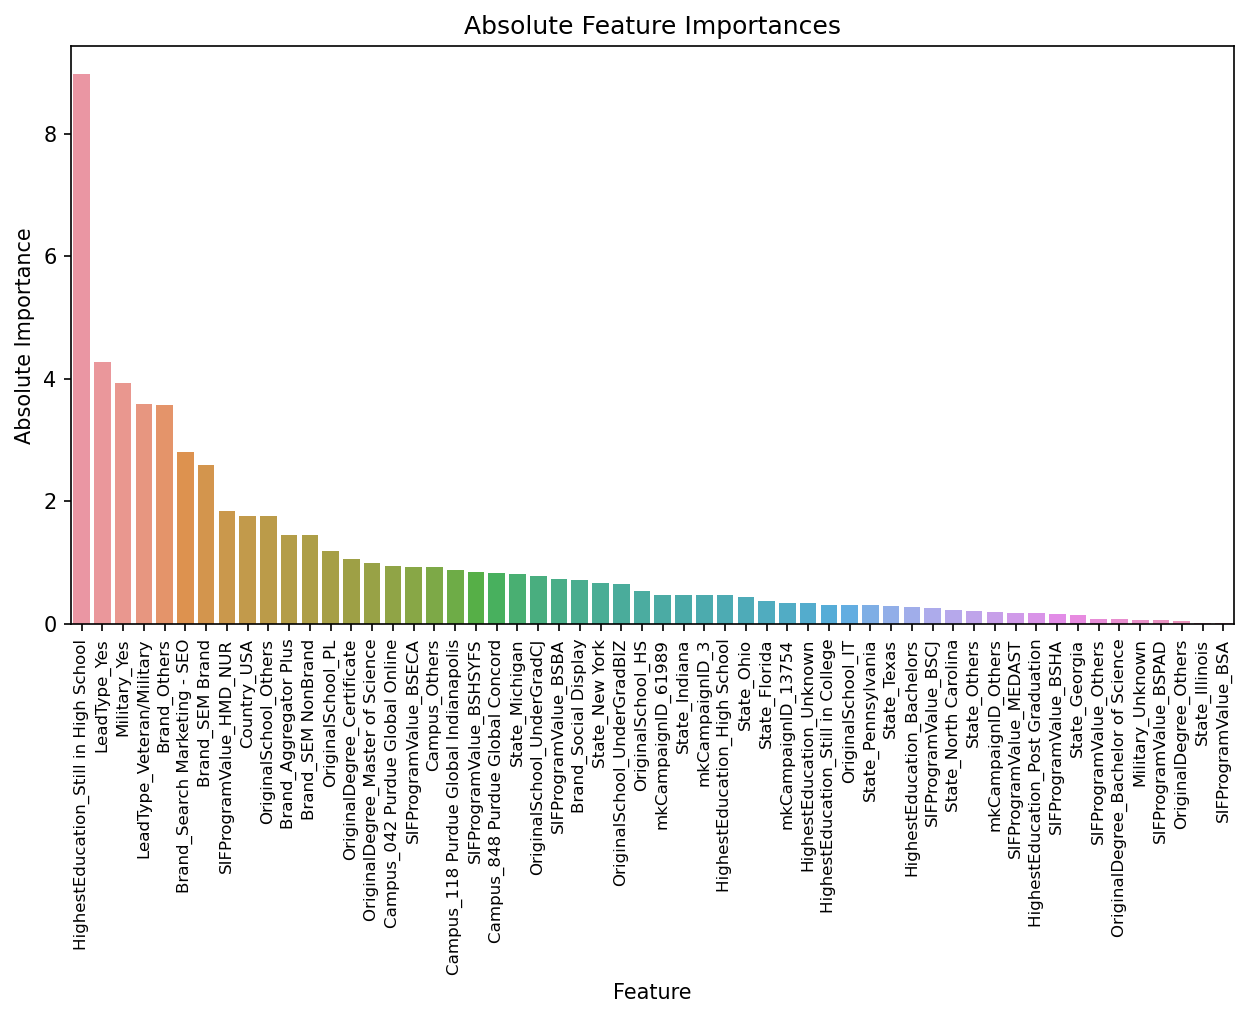

In [171]:
plt.figure(figsize=(10,5),dpi=150)
sns.barplot(data = feature_importance,x = 'Feature',y ='Absolute Importance')
plt.xticks(rotation=90, fontsize=8)
plt.title("Absolute Feature Importances")
plt.show()

#### Since our hyperparameter tuning is not leading to any changes in the output scores, but the feature importances are changing

In [173]:
# Removing the non-important features and fitting the model again

trim_features = feature_importance[feature_importance['Importance'].abs() > 1].drop('index', axis=1)['Feature'].to_list()
trim_features

['HighestEducation_Still in High School',
 'LeadType_Yes',
 'Military_Yes',
 'LeadType_Veteran/Military',
 'Brand_Others',
 'Brand_Search Marketing - SEO',
 'Brand_SEM Brand',
 'SIFProgramValue_HMD_NUR',
 'Country_USA',
 'OriginalSchool_Others',
 'Brand_Aggregator Plus',
 'Brand_SEM NonBrand',
 'OriginalSchool_PL',
 'OriginalDegree_Certificate']

In [174]:
#Initialize and fit the model only on important features
LogReg4 = LogisticRegression(random_state=42,solver='liblinear', C=525,max_iter=30, class_weight=None, penalty = 'l1',tol= 1e-05 )
LogReg4.fit(X_train_resampled_2[trim_features], y_train_resampled_2)

# Get Predictions
y_fit = LogReg4.predict(X_train_resampled_2[trim_features])
y_pred = LogReg4.predict(X_test_encoded_df[trim_features])

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     24160
           1       0.05      0.60      0.10       315

    accuracy                           0.86     24475
   macro avg       0.52      0.73      0.51     24475
weighted avg       0.98      0.86      0.91     24475



C:\Users\kharb\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [175]:
#Evaluate the Model
train_perf_clfn_hyp_tun["LogReg4"] = get_evaluation_metrics_clfn(y_train_resampled_2,y_fit)
test_perf_clfn_hyp_tun["LogReg4"] = get_evaluation_metrics_clfn(y_test,y_pred)

In [176]:
train_perf_clfn_hyp_tun

,LogReg1,LogReg2,LogReg3,LogReg4
Accuracy,0.774,0.774,0.774,0.754
AUC-ROC,0.774,0.774,0.774,0.754
Precision,0.774,0.774,0.774,0.822
Recall,0.774,0.774,0.774,0.648
F1Score,0.774,0.774,0.774,0.724


In [177]:
test_perf_clfn_hyp_tun

,LogReg1,LogReg2,LogReg3,LogReg4
Accuracy,0.773,0.773,0.773,0.856
AUC-ROC,0.745,0.745,0.745,0.731
Precision,0.040,0.040,0.040,0.053
Recall,0.717,0.717,0.717,0.603
F1Score,0.075,0.075,0.075,0.097


In [178]:
# Feature importance dataframe
feature_importance = pd.DataFrame({'Feature': X_train_resampled_2[trim_features].columns,'Importance': LogReg4.coef_[0]})

# Display the feature importance sorted by absolute value
feature_importance['Absolute Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Importance', ascending=False).reset_index()
print(feature_importance[['Feature', 'Importance']])


                Feature  Importance
0   HighestEducation...   -8.676088
1          Brand_Others    3.970753
2          LeadType_Yes    3.740403
3   Brand_Search Mar...    3.280689
4          Military_Yes   -3.229678
5       Brand_SEM Brand    3.088068
6   LeadType_Veteran...    2.681944
7    Brand_SEM NonBrand    1.964532
8   SIFProgramValue_...   -1.836885
9           Country_USA    1.723945
10  Brand_Aggregator...    1.599456
11  OriginalDegree_C...   -0.971379
12    OriginalSchool_PL   -0.597242
13  OriginalSchool_O...   -0.345041


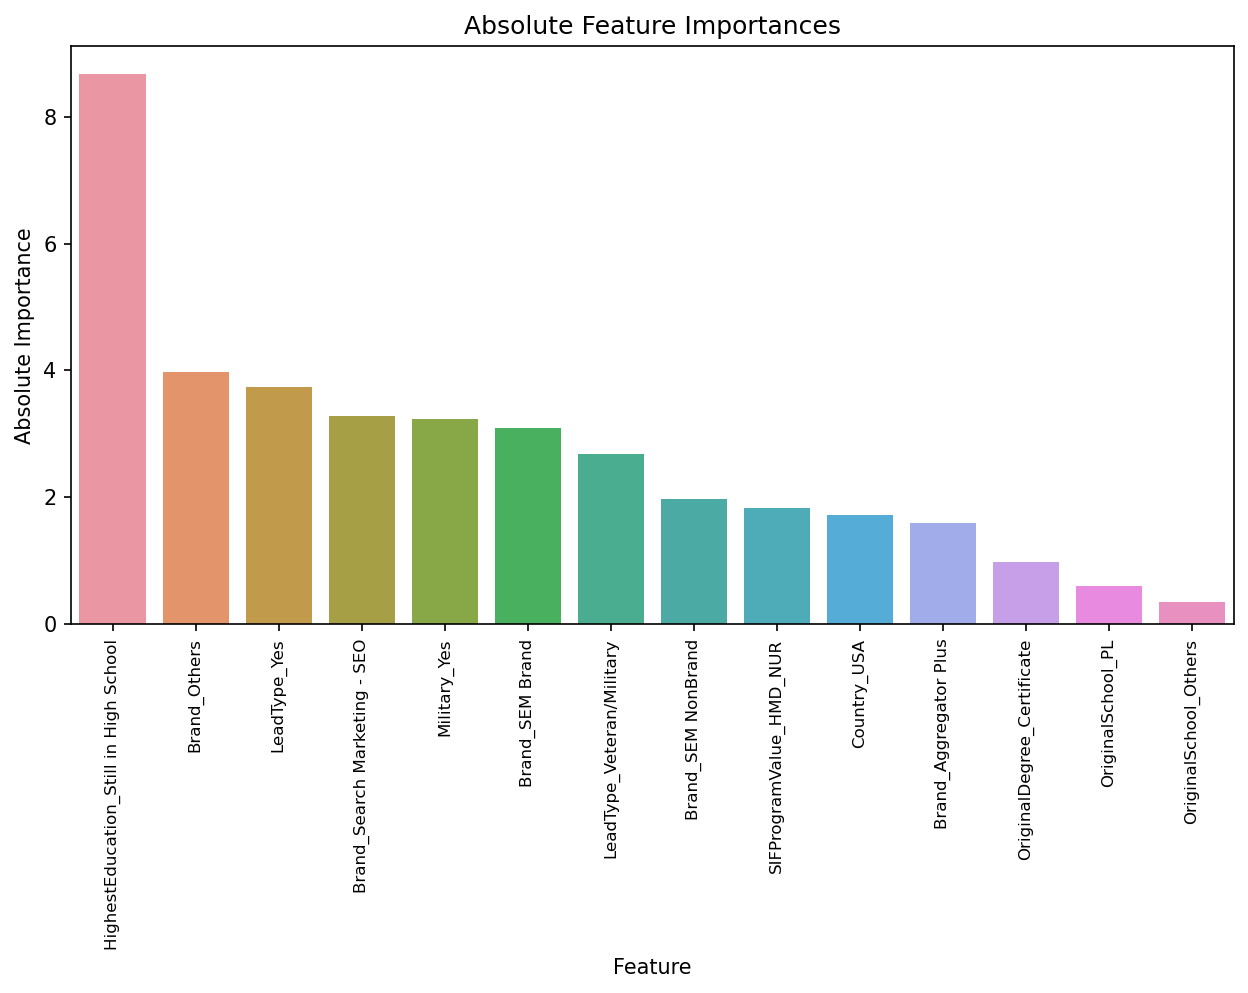

In [179]:
plt.figure(figsize=(10,5),dpi=150)
sns.barplot(data = feature_importance,x = 'Feature',y ='Absolute Importance')
plt.xticks(rotation=90, fontsize=8)
plt.title("Absolute Feature Importances")
plt.show()

## Script for JobLib file

In [358]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib


leads_data = pd.read_csv('D:/Projects & Datasets/Case Study/Data Scientist Case Study/prob_2/sample_lead_data.csv',index_col=0)


# Data Cleaning and Preparation
# Removing Redundant & Sparse Columns
leads_data = leads_data.drop(columns=['VendorInternalCode', 'Address', 'Zip'], axis=1)
leads_data = leads_data.drop(columns=['VendorDescription', 'MkMarketingChannel'], axis=1)
leads_data = leads_data.drop(columns=['MkVendorID', 'mkMarketingChannelId'], axis=1)
leads_data = leads_data.drop(columns=['SyCampusID'], axis=1)
leads_data = leads_data.drop(columns=['SourceCode'], axis=1)
leads_data = leads_data.drop(columns=['City'], axis=1)
leads_data = leads_data.drop(columns=['MISC_SourDes'], axis=1)

# Standardizing Columns
columns_to_clean = ['HighestEducation','LeadType','OriginalDegree','Military', 'Country', 'State','Campus','OriginalSchool','SIFProgramValue']

for column in columns_to_clean:
    leads_data[column] = leads_data[column].str.replace('"', '', regex=False)


# 'HighestEducation'
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['BachelorDegree','Bachelors'],'Bachelors') 
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['SomeCollegeLessThan2','SomeCollegeMoreThan2','SomeCollegeLes',
                                                                        'Some College (1-19 Quarter Credit)','Some College (20 or more Quarter Credit)',
                                                                        ],'Still in College') 
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['Associates','AssocDegree'],'Associate') 
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['HighSchool','GED','HSGED','NursingDiploma'],'High School') 
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['Still in High School','Still in high school'],'Still in High School')
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['Masters','MasterDegree','DoctoralDegree',
                                                                        'PostGrad','Masters'],'Post Graduation') 
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['SelectEducation','NONE','','NoEduc',
                                                                        'Select One','0'],'Unknown')
leads_data['HighestEducation'] = leads_data['HighestEducation'].replace(['Some College'],'In College')
leads_data['HighestEducation'].fillna('Unknown', inplace=True)

# 'LeadType'
leads_data['LeadType'] = leads_data['LeadType'].replace(['Veteran','MilitarySpouse','Military','VeteranSpouse',
                                                         'NationalGuard','Reserve','DOD'],'Veteran/Military')
leads_data['LeadType'] = leads_data['LeadType'].replace(['Yes','Active'],'Yes')
leads_data['LeadType'].fillna('Default', inplace=True)

#  'OriginalDegree'
leads_data['OriginalDegree'] = leads_data['OriginalDegree'].replace(['Bachelor of Science'],'Bachelor of Science')
leads_data['OriginalDegree'] = leads_data['OriginalDegree'].replace(['Associate of Science'],'Associate of Science')
leads_data['OriginalDegree'] = leads_data['OriginalDegree'].replace(['Master of Science'],'Master of Science')
leads_data['OriginalDegree'] = leads_data['OriginalDegree'].replace(['Certificate'],'Certificate')
leads_data['OriginalDegree'] = leads_data['OriginalDegree'].replace(['Juris Doctor','Graduate Level Certificate',
                                                                     'Microcredential','Doctorate in Nursing Practice'],'Others')

#  'OriginalDegree'
threshold = 0.02 * len(leads_data)
value_counts = leads_data['OriginalSchool'].value_counts()
leads_data['OriginalSchool'] = leads_data['OriginalSchool'].apply(lambda x: x if pd.isna(x) or value_counts[x] >= threshold else 'Others')
leads_data = leads_data.dropna(subset='OriginalDegree',axis=0)

#  'Military'
leads_data['Military'] = leads_data['Military'].replace(['No','NO','0'],'No')
leads_data['Military'] = leads_data['Military'].replace(['Yes','YES','MilitarySpouse'],'Yes')
leads_data['Military'] = leads_data['Military'].replace([''],'Unknown')
leads_data['Military'] = leads_data['Military'].fillna('Unknown', inplace=True)

# 'Campus' 
threshold = 0.005 * len(leads_data)
value_counts = leads_data['Campus'].value_counts()
leads_data['Campus'] = leads_data['Campus'].apply(lambda x: x if pd.isna(x) or value_counts[x] >= threshold else 'Others')

# 'Country' 
leads_data['Country'] = leads_data['Country'].apply(lambda x: 'USA' if x == 'United States' else ('Others' if pd.notna(x) else x))
us_states = list(leads_data[(leads_data['Country'].isnull()) & (leads_data['State'] != '')]['State'])
leads_data.loc[leads_data['State'].isin(us_states) & leads_data['Country'].isnull(), 'Country'] = 'USA'
leads_data = leads_data.dropna(subset='Country',axis=0)

# 'State'
threshold = 0.03 * len(leads_data)
value_counts = leads_data['State'].value_counts()
leads_data['State'] = leads_data['State'].apply(lambda x: x if pd.isna(x) or value_counts[x] >= threshold else 'Others')
leads_data['State'] = leads_data['State'].fillna('Others')

# 'SIFProgramValue'
threshold = 0.025 * len(leads_data)
value_counts = leads_data['SIFProgramValue'].value_counts()
leads_data['SIFProgramValue'] = leads_data['SIFProgramValue'].apply(lambda x: x if pd.isna(x) or value_counts[x] >= threshold else 'Others')
leads_data['SIFProgramValue'] = leads_data['SIFProgramValue'].fillna('Others')

# 'Brand'
threshold = 0.01 * len(leads_data)
value_counts = leads_data['Brand'].value_counts()
leads_data['Brand'] = leads_data['Brand'].apply(lambda x: x if value_counts[x] >= threshold else 'Others')

# 'mkCampaignID' 
threshold = 0.01 * len(leads_data)
value_counts = leads_data['mkCampaignID'].value_counts()
leads_data['mkCampaignID'] = leads_data['mkCampaignID'].apply(lambda x: x if value_counts[x] >= threshold else 'Others')


# Convert all columns to object type
for col in leads_data.columns:
    leads_data[col] = leads_data[col].astype('object')


# Train-Test Split
X = leads_data.drop('AcademicStarts', axis=1)
y = leads_data['AcademicStarts']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
y_train = y_train.astype('category')
y_test = y_test.astype('category')

# One-Hot Encoding
# Converting 'mkCampaignID' to string to ensure consistent types for encoding
X_train['mkCampaignID'] = X_train['mkCampaignID'].astype(str)
X_test['mkCampaignID'] = X_test['mkCampaignID'].astype(str)

one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded = one_hot_encoder.fit_transform(X_train)
X_test_encoded = one_hot_encoder.transform(X_test)

# Converting to DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=one_hot_encoder.get_feature_names_out()).reset_index(drop=True)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=one_hot_encoder.get_feature_names_out()).reset_index(drop=True)


# Handling Class Imbalance with Tomek Links and SMOTE
# Apply SMOTE
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled_2, y_train_resampled_2 = smote_tomek.fit_resample(X_train_encoded_df, y_train)


# Training Logistic Regression Model that we got from hyperparameter tuning
LogReg3 = LogisticRegression(random_state=42, solver='liblinear', C=525, max_iter=30, class_weight=None, penalty='l1', tol=1e-5)
LogReg3.fit(X_train_resampled_2, y_train_resampled_2)

# Getting Predictions
y_fit = LogReg3.predict(X_train_resampled_2)
y_pred = LogReg3.predict(X_test_encoded_df)

print(classification_report(y_test, y_pred))


# Save the Model and Preprocessing Steps
joblib.dump((one_hot_encoder, smote_tomek, LogReg3), 'model_pipeline.pkl')


              precision    recall  f1-score   support

           0       1.00      0.77      0.87     24160
           1       0.04      0.70      0.07       315

    accuracy                           0.77     24475
   macro avg       0.52      0.74      0.47     24475
weighted avg       0.98      0.77      0.86     24475



C:\Users\kharb\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['model_pipeline.pkl']